# Projet de Machine Learning

Notebook Python avec les codes utilisés pour le rapport final.<br>
Auteurs : Juan AYALA, Jeong Hwan KO, Alice LALOUE, Aldo MELLADO AGUILAR.<br>
4A MA - Groupes A et B<br>
2020 - 2021

## Importation des librairies 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os

from functions import *
from tensorflow import keras

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 16
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize': (15, 6)})

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
# Cette cellule permet de centrer les figures automatiquement
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Obtenir les données

In [3]:
spotify_data = pd.read_csv("data/spotify-extr.txt", sep=" ")

# Description de l'ensemble du jeu de données

In [4]:
spotify_data.head()

,valence,year,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,pop.class
161704,0.647,1975,0.4490,0.376,298840,0.827,0.007880,B,0.466,-7.604,1,25,0.3990,170.475,C
168077,0.150,2008,0.8990,0.508,236800,0.169,0.000011,Ab,0.136,-11.332,1,42,0.0553,107.477,B
35922,0.423,2007,0.0185,0.470,301093,0.878,0.083900,B,0.276,-5.576,0,65,0.0377,150.093,A
135823,0.302,1995,0.0384,0.176,142200,0.980,0.552000,B,0.237,-3.154,1,36,0.0721,172.566,C
165395,0.828,1994,0.5310,0.705,187800,0.625,0.000008,G,0.348,-11.963,0,38,0.0639,97.831,C


In [5]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 161704 to 90217
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valence           10000 non-null  float64
 1   year              10000 non-null  int64  
 2   acousticness      10000 non-null  float64
 3   danceability      10000 non-null  float64
 4   duration          10000 non-null  int64  
 5   energy            10000 non-null  float64
 6   instrumentalness  10000 non-null  float64
 7   key               10000 non-null  object 
 8   liveness          10000 non-null  float64
 9   loudness          10000 non-null  float64
 10  mode              10000 non-null  int64  
 11  popularity        10000 non-null  int64  
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  float64
 14  pop.class         10000 non-null  object 
dtypes: float64(9), int64(4), object(2)
memory usage: 1.2+ MB


On n'a pas de valeurs manquantes donc on n'a pas besoin de les retravailler.

Les variables explicatives sont :
* `valence` : la positivité de la chanson, vaut 1 si la chanson est très joyeuse, 0 sinon ;
* `year` : année de sortie ;
* `acousticness` : mesure "l'acousticité" de la chanson ;
* `danceability` : mesure la "dançabilite" d'une chanson ;
* `duration` : durée d'une chanson en millisecondes ;
* `energy` : l'énergie de la chanson, vaut 1 si la chanson est très énergétique, 0 sinon ;
* `intrumentalness` : taux d'instrumentalisation, vaut 1 s'il n'y a aucune voix présente dans la chanson, 0 sinon ; 
* `key` : tonalité de la musique (ex : A=la), ne prend pas en compte la distinction majeur/mineur ;
* `liveness` : taux de prestation en live, vaut 1 si la chanson ne comporte que de la musique (sans sons à intérêts non-musicaux), 0 sinon ;
* `loudness` : intensité sonore de la chanson
* `mode` : variable binaire qui indique si la chanson commence par une progression d'accords majeure (1) ou non (0)
* `speechiness` : taux de vocaux dans la chanson, vaut 1 si la chanson comporte de la voix tout le long, 0 sinon ;
* `tempo` :  tempo de la chanson en beats par minute (bpm)

Notre objectif consiste à prédire la valeur de `pop.class` et de `popularity`, c'est-à-dire la popularité d'une chanson, soit comme un entier entre 0 et 100, soit comme une classe $A$, $B$, $C$ ou $D$.

In [6]:
spotify_data.describe()

,valence,year,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.532815,1977.026200,0.495719,0.540029,2.272151e+05,0.487500,0.164947,0.204063,-11.437683,0.71470,31.558100,0.101815,116.865750
std,0.262431,26.000068,0.377681,0.176193,1.124568e+05,0.267729,0.313327,0.173221,5.787993,0.45158,21.915904,0.168111,30.969039
min,0.000000,1921.000000,0.000000,0.000000,5.991000e+03,0.000000,0.000000,0.000000,-60.000000,0.00000,0.000000,0.000000,0.000000
25%,0.324000,1956.000000,0.092675,0.417000,1.690670e+05,0.262000,0.000000,0.097800,-14.557000,0.00000,11.000000,0.035000,93.564500
50%,0.543000,1978.000000,0.504000,0.550000,2.065295e+05,0.476000,0.000174,0.135000,-10.552500,1.00000,33.000000,0.045400,114.437500
75%,0.751000,1999.000000,0.889250,0.671000,2.597330e+05,0.708000,0.087100,0.256000,-7.115500,1.00000,48.250000,0.078600,135.470000
max,0.993000,2020.000000,0.996000,0.988000,2.703227e+06,1.000000,1.000000,0.991000,1.342000,1.00000,93.000000,0.969000,214.419000


Dans notre jeu de données, les variables qualitatives sont :
* `pop.class`,
* `key`,
* `mode`.

Le reste des variables sont quantitatives.

In [7]:
data_qual = spotify_data[["pop.class", "mode", "key"]]
data_qual.head()

,pop.class,mode,key
161704,C,1,B
168077,B,1,Ab
35922,A,0,B
135823,C,1,B
165395,C,0,G


In [8]:
print("Valeurs de 'pop.class' :", sorted(set(data_qual["pop.class"].values)), "\n")
print("Valeurs de 'key':", sorted(set(data_qual["key"].values)), "\n")
print("Valeurs de 'mode' :", set(data_qual["mode"].values))

Valeurs de 'pop.class' : ['A', 'B', 'C', 'D'] 

Valeurs de 'key': ['A', 'Ab', 'B', 'Bb', 'C', 'D', 'Db', 'E', 'Eb', 'F', 'G', 'Gb'] 

Valeurs de 'mode' : {0, 1}


On transforme les variables qualitatives en catégories pour mieux traiter les données.

In [9]:
spotify_data["key"] = pd.Categorical(spotify_data["key"], ordered=False)
spotify_data["mode"] = pd.Categorical(spotify_data["mode"], ordered=False)
spotify_data["pop.class"] = pd.Categorical(spotify_data["pop.class"],
                                           ordered=True,
                                           categories=['D', 'C', 'B', 'A'])

In [10]:
spotify_data.dtypes

valence              float64
year                   int64
acousticness         float64
danceability         float64
duration               int64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                category
popularity             int64
speechiness          float64
tempo                float64
pop.class           category
dtype: object

# Analyses uni et multidimensionnelles

## Variables qualitatives

On commence par analyser les variables qualitatives `pop.class`, `key` et `mode`.

<b>Classe de popularité</b>

Cette variable a été créée en amont de l'obtention des données. C'est notre variable à prédire en classification.

Saving figure pop_class_frequencies


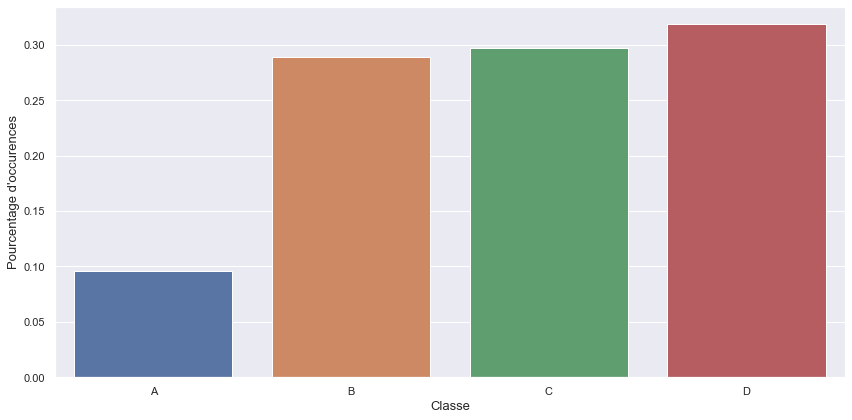

In [11]:
pop_class_count = data_qual["pop.class"].value_counts(normalize=True).iloc[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=pop_class_count.index, y=pop_class_count.values)
#plt.title("Fréquence des classes de popularité", fontsize=14)
plt.ylabel("Pourcentage d'occurences", fontsize=13)
plt.xlabel("Classe", fontsize=13)
save_fig("pop_class_frequencies")
plt.show()

On voit qu'il y a une distribution uniforme des chansons par classe, sauf pour la classe `A`, qui comprend moins de 10% des chansons. Ceci risque de poser problème dans la suite en termes de prédiction.

<b>Clé</b>

Saving figure keys_frequencies


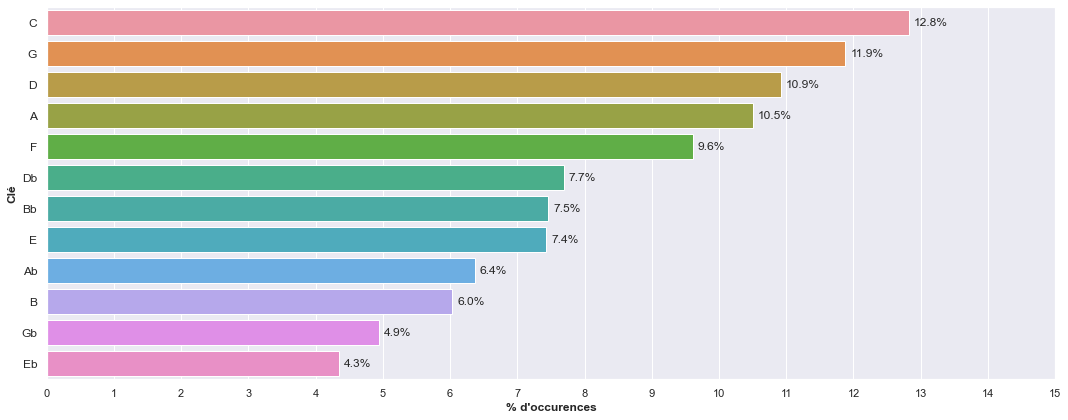

In [12]:
fig, ax = plt.subplots()
key_count = spotify_data['key'].value_counts(
    normalize=True, sort=True, ascending=True) * 100
y_ticks = spotify_data['key'].value_counts().index

sns.barplot(x=key_count.values, y=y_ticks, data=key_count, orient='h')
plt.xlabel("% d'occurences", fontsize=12, weight='bold')
plt.ylabel('Clé', fontsize=12, weight='bold')
ax.set_xticks(ticks=range(0, 16, 1))
ax.set_yticklabels(labels=y_ticks, fontsize=12)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    label = f'{x_value:.1f}%'

    plt.annotate(label, (x_value, y_value),
                 xytext=(5, 0),
                 textcoords="offset points",
                 va='center',
                 ha='left')

#plt.title("Distribution de 'key'", fontsize=14)
save_fig('keys_frequencies')
plt.show()

Saving figure popularity_by_key


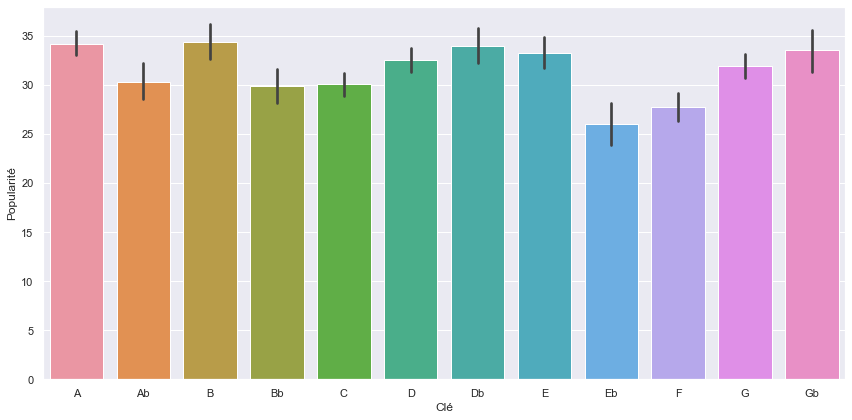

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(x='key', y='popularity', data=spotify_data)
#plt.title("Popularité selon la clé", fontsize=14)
plt.ylabel("Popularité")
plt.xlabel("Clé")
save_fig("popularity_by_key")
plt.show()

Les variances de la popularité dans chacune des valeurs de `key` est petite donc nous n'avons pas besoin de transformer ces données.

Saving figure boxplot_of_popularity_by_key


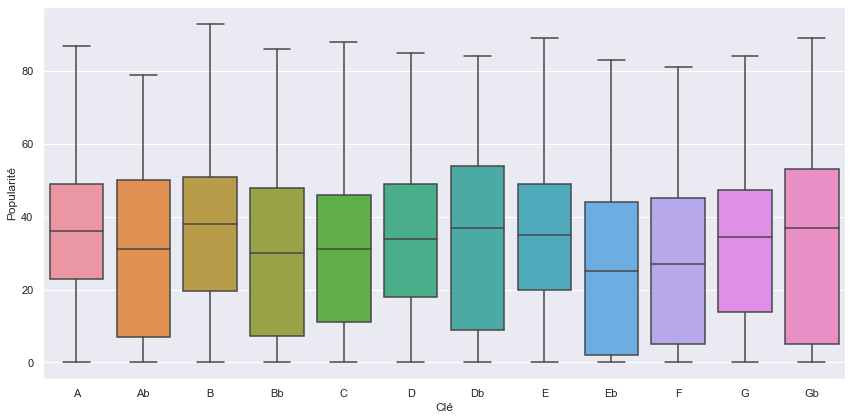

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='key', y='popularity', data=spotify_data)
#plt.title("Popularité selon la clé", fontsize=14)
plt.ylabel("Popularité")
plt.xlabel("Clé")
save_fig("boxplot_of_popularity_by_key")
plt.show()

De la même façon, la distribution de la popularité reste plutôt uniforme par clé : les boîtes ont une taille similaire et la médiane est au même niveau.

<b>Mode</b>

Saving figure mode_frequencies


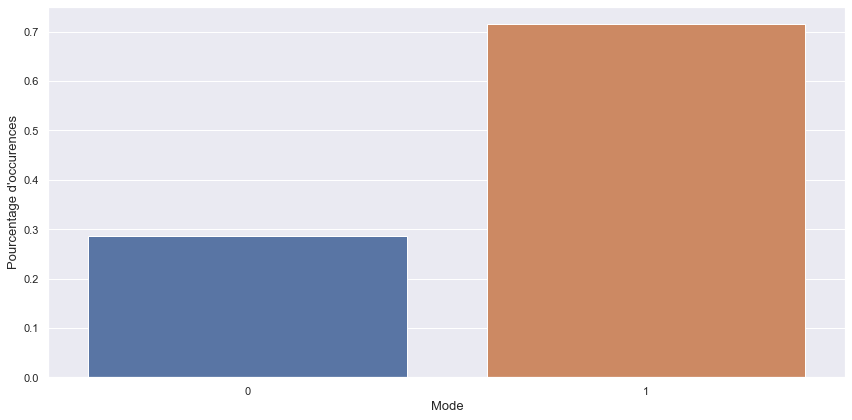

In [15]:
mode_count = spotify_data["mode"].value_counts(normalize=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=mode_count.index, y=mode_count.values)
#plt.title("Fréquence des modes", fontsize=14)
plt.ylabel("Pourcentage d'occurences", fontsize=13)
plt.xlabel("Mode", fontsize=13)
save_fig("mode_frequencies")
plt.show()

La distribution selon `mode` est inégale : il y a 30% et 70% des chansons pour `mode` = 0 et `mode` = 1 respectivement.

Saving figure popularity_by_mode


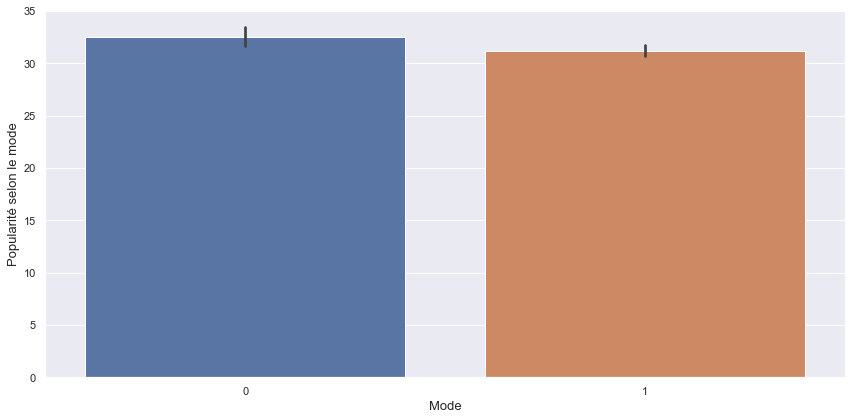

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x='mode', y='popularity', data=spotify_data)
#plt.title("Fréquence des modes", fontsize=14)
plt.ylabel("Popularité selon le mode", fontsize=13)
plt.xlabel("Mode", fontsize=13)
save_fig("popularity_by_mode")
plt.show()

Par contre, la popularité est similaire selon le mode.

Saving figure boxplot_of_popularity_by_mode


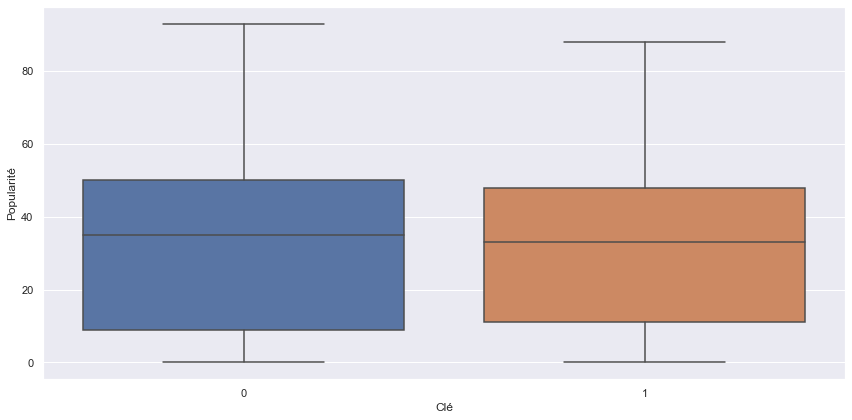

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='mode', y='popularity', data=spotify_data)
#plt.title("Popularité selon la clé", fontsize=14)
plt.ylabel("Popularité")
plt.xlabel("Clé")
save_fig("boxplot_of_popularity_by_mode")
plt.show()

On regroupe toutes les variables qualitatives en un barplot :

Saving figure popularity_by_key_and_mode


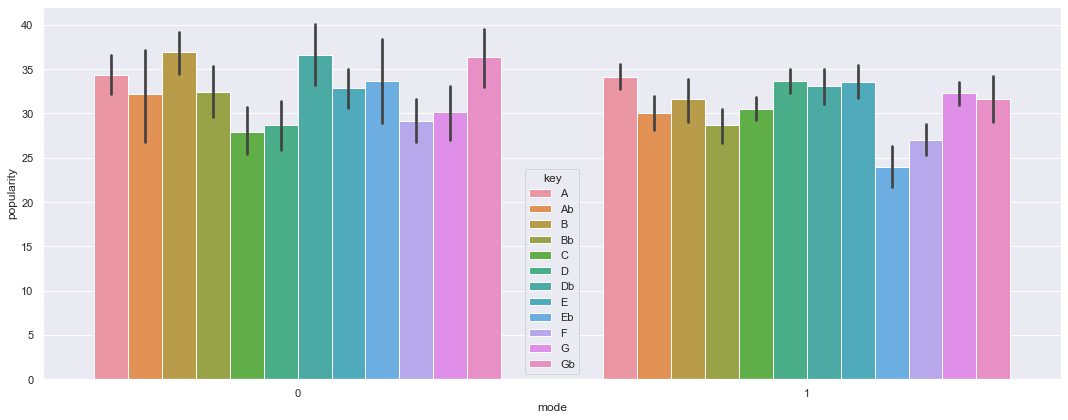

In [18]:
sns.barplot(x='mode', y='popularity', hue='key', data=spotify_data)
#plt.title("Popularité selon la clé et le mode", fontsize=14)
save_fig("popularity_by_key_and_mode")
plt.show()

Saving figure boxplot_popularity_by_key_and_mode


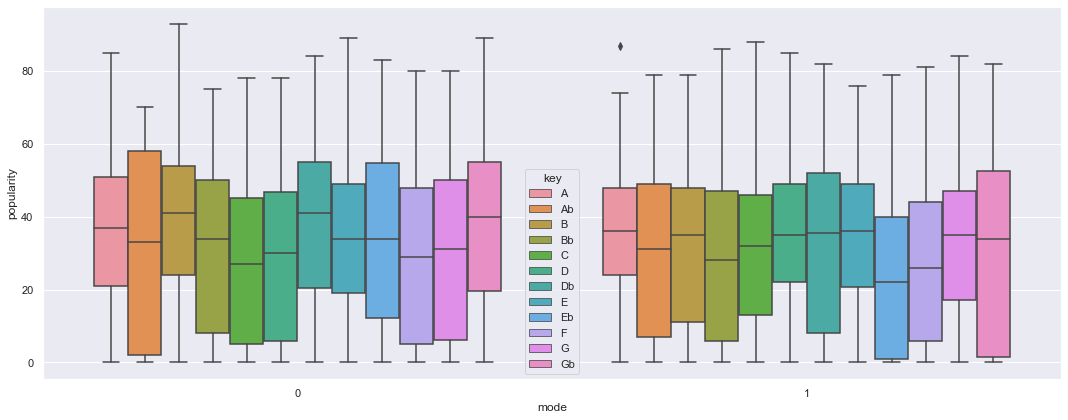

In [19]:
sns.boxplot(x='mode', y='popularity', hue='key', data=spotify_data)
#plt.title("Popularité selon la clé et le mode", fontsize=14)
save_fig("boxplot_popularity_by_key_and_mode")
plt.show()

## Variables quantitatives

On commence par visualiser la corrélation entre les variables quantitatives :

In [20]:
data_quant = spotify_data[spotify_data.columns.difference(
    ['key', 'mode', 'pop.class'], sort=False)]
data_quant.keys()

Index(['valence', 'year', 'acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo'],
      dtype='object')

Saving figure correlation_square_matrix


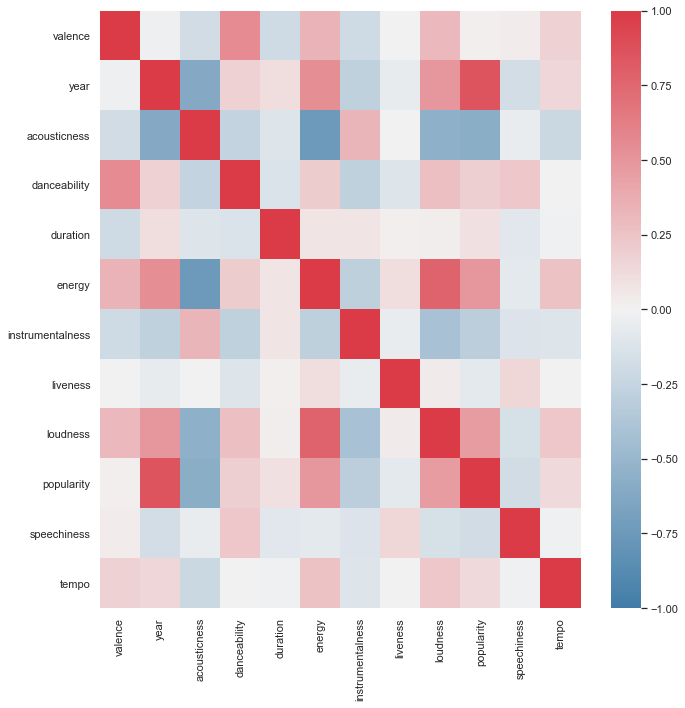

In [21]:
corr_matrix = data_quant.corr()
cmap = sns.diverging_palette(240, 10, as_cmap=True)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap=cmap, center=0, vmin=-1, vmax=1)
#plt.title("Matrice de corrélation")
save_fig("correlation_square_matrix")
plt.show()

Ce graphique nous montre qu'il y a certaines variables qui ont une forte corrélation. Par exemple, il y a une forte corrélation négative entre les variables `energy` et `acousticness`. Cela a du sens vu que les chansons acoustiques sont plus tranquilles (moins énergiques) que celles qui ne sont pas acoustiques. De même, `energy` et `loudness` sont positivement corrélées, ce qui est attendu vu que les chansons bruyantes ont souvent plus d'énergie.
<br>
On voit aussi que plus une chanson est acoustique, moins elle est populaire, vu que les variables `acousticness` et `popularity` ont une forte corrélation négative.

In [22]:
series = np.abs(corr_matrix['popularity']).sort_values(ascending=False)
print("Les variables les plus corrélées avec la variable 'popularity' sont : ")
for i, row in enumerate(series):
    if 0.2 <= row < 1:
        print(f'{series.index[i]:17} --> {row: .2f} (abs)')

Les variables les plus corrélées avec la variable 'popularity' sont : 
year              -->  0.86 (abs)
acousticness      -->  0.58 (abs)
energy            -->  0.50 (abs)
loudness          -->  0.46 (abs)
instrumentalness  -->  0.30 (abs)


Voici leurs distributions avec boxplot :

In [23]:
# plt.scatter(spotify_data['energy'], spotify_data['acousticness'], alpha=.5)
# plt.xlabel("Energy")
# plt.ylabel("Acousticness")
# plt.title("Acousticité des chansons en fonction de leur énergie")
# save_fig("acousticness_by_energy")
# plt.show()

In [24]:
# histograms_plot(data_quant, data_quant.columns, 4, 3)
# save_fig("quantitative_data_histograms")
# plt.show()

Saving figure hist_boxplot_of_data


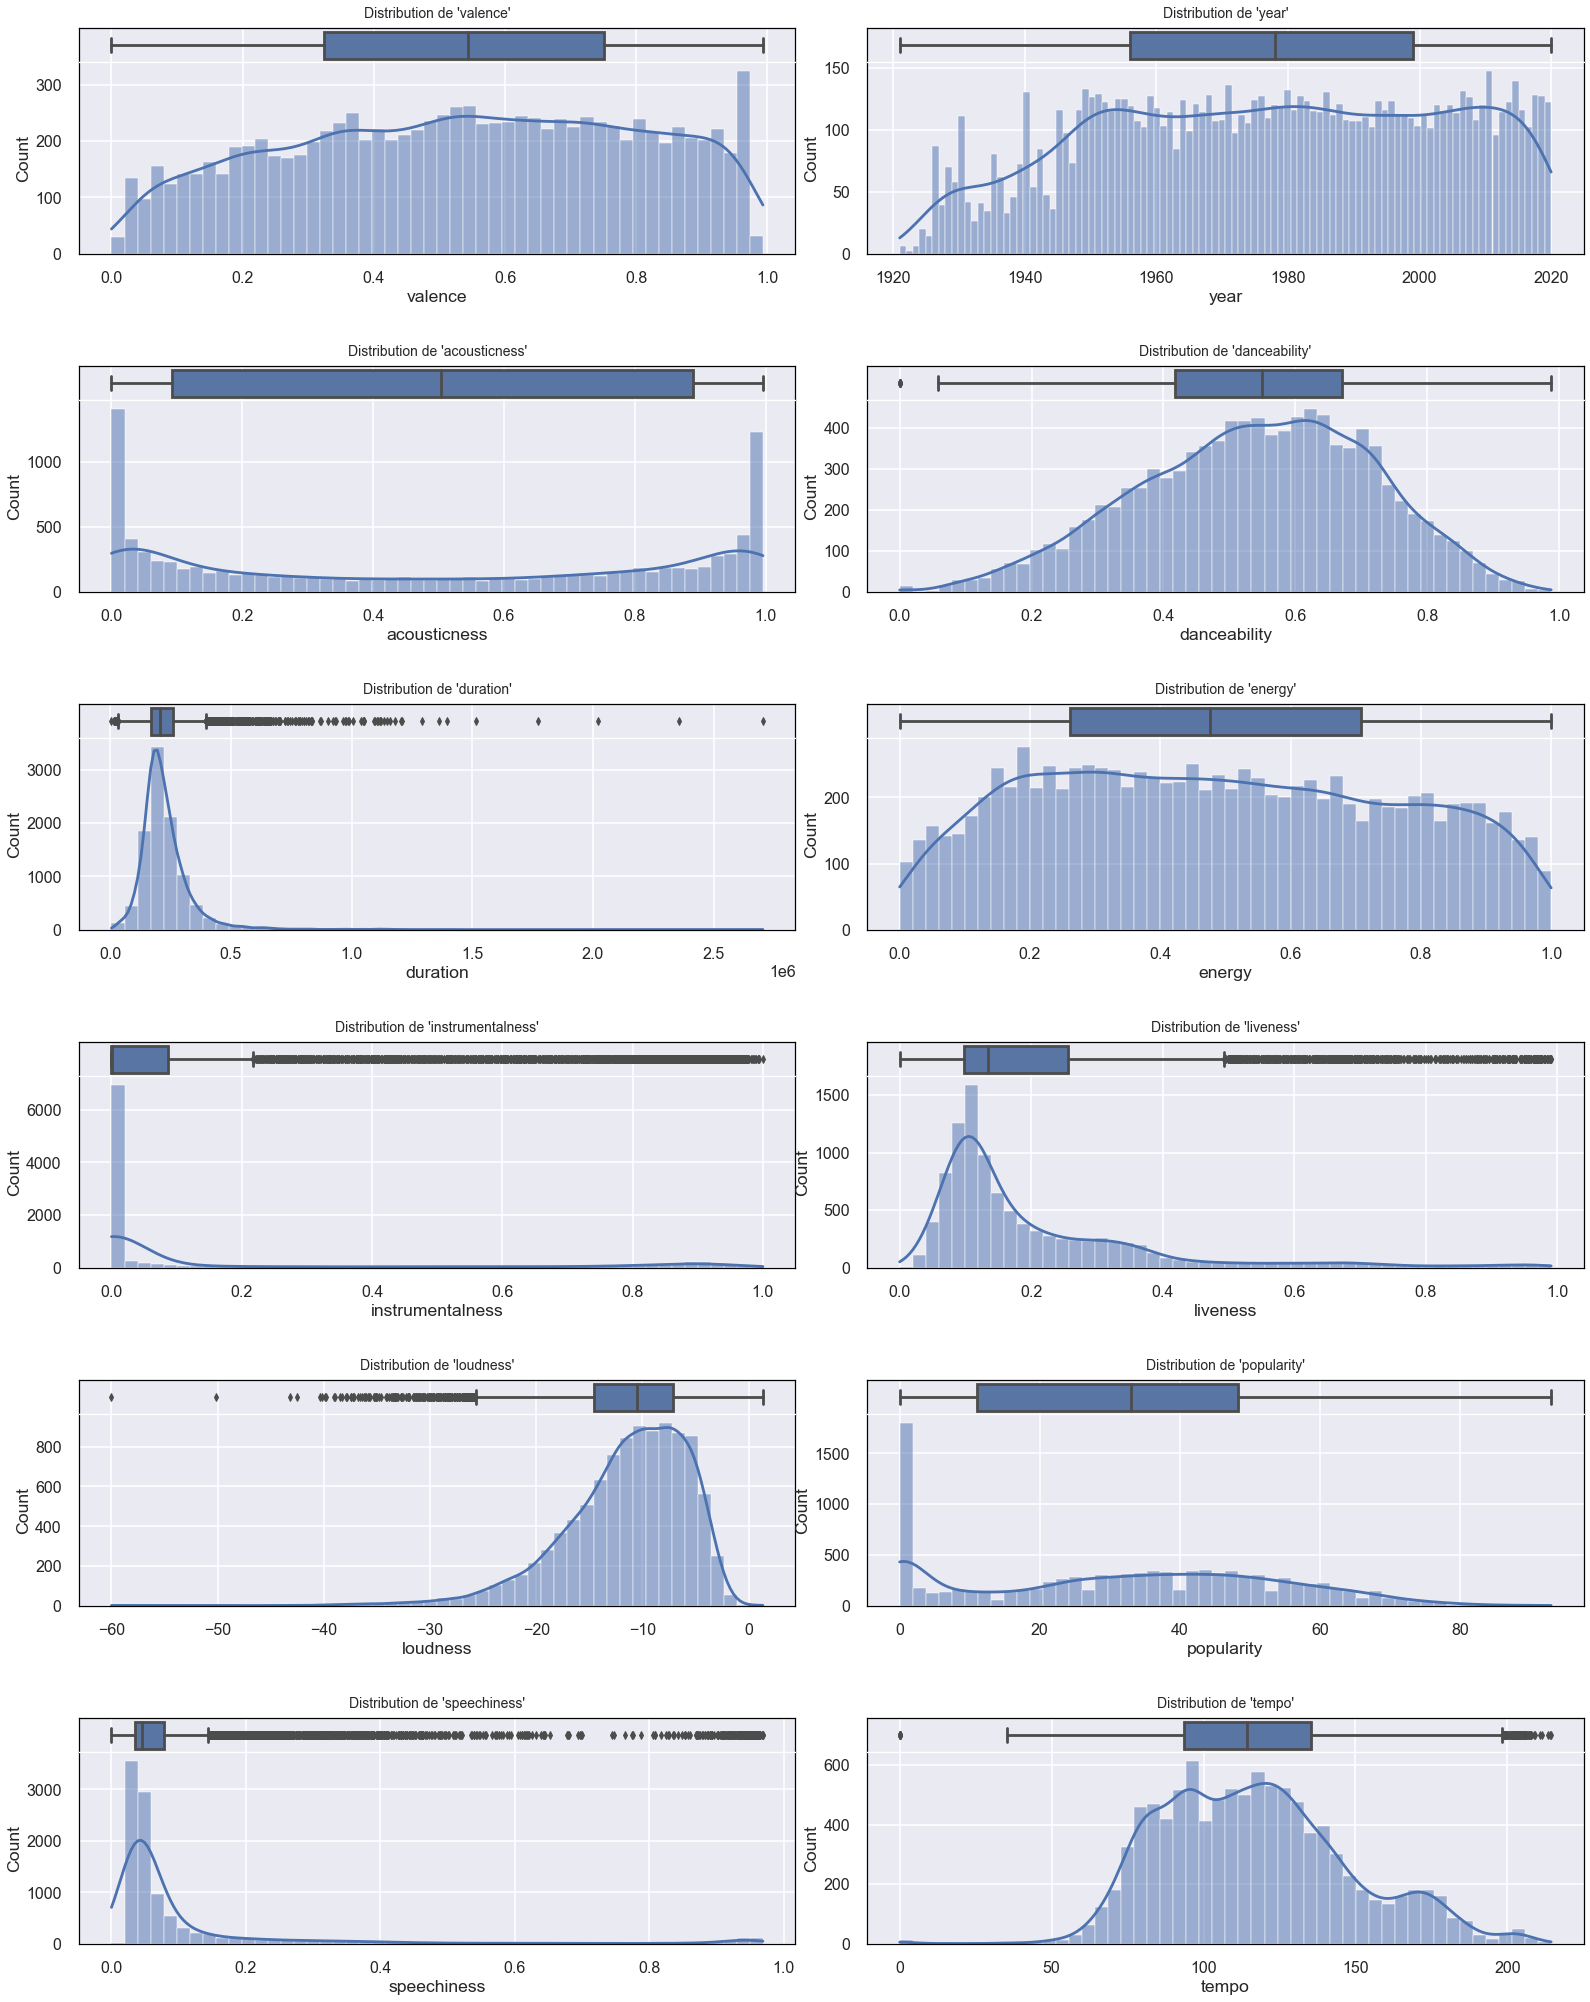

In [25]:
plt.style.use('seaborn-poster')

fig = plt.figure(figsize=(22, 28))
outer = fig.add_gridspec(6, 2, wspace=0.1, hspace=0.5, left=0.03,
                         right=0.98, bottom=0.03, top=0.98)

a = 0
for i in range(6):
    for j in range(2):
        feature = data_quant.columns[a]
        inner = outer[i, j].subgridspec(2, 1, wspace=0.2, hspace=0,
                                        height_ratios=[0.15, 0.85])
        axs = inner.subplots(sharex=True)

        sns.boxplot(data=data_quant, x=feature, orient='h', ax=axs[0])
        sns.histplot(data=data_quant, x=feature,
                     bins=50 if a != 1 else 100,
                     ax=axs[1], kde=True)

        axs[0].spines['top'].set_color('black')
        axs[0].spines['right'].set_color('black')
        axs[0].spines['left'].set_color('black')

        axs[1].set_title("Distribution de '" + feature + "'", y=1.2, fontsize=14)
        axs[1].spines['bottom'].set_color('black')
        axs[1].spines['right'].set_color('black')
        axs[1].spines['left'].set_color('black')

        a += 1

    #fig.suptitle('Distribution des variables quantitatives', y=1.01, fontsize=20)
save_fig('hist_boxplot_of_data', tight_layout=False)
plt.show()

Voici une étude plus approfondie de chaque variable quantitative :

<b>Acousticness</b>

Saving figure mean_popularity_by_acousticness


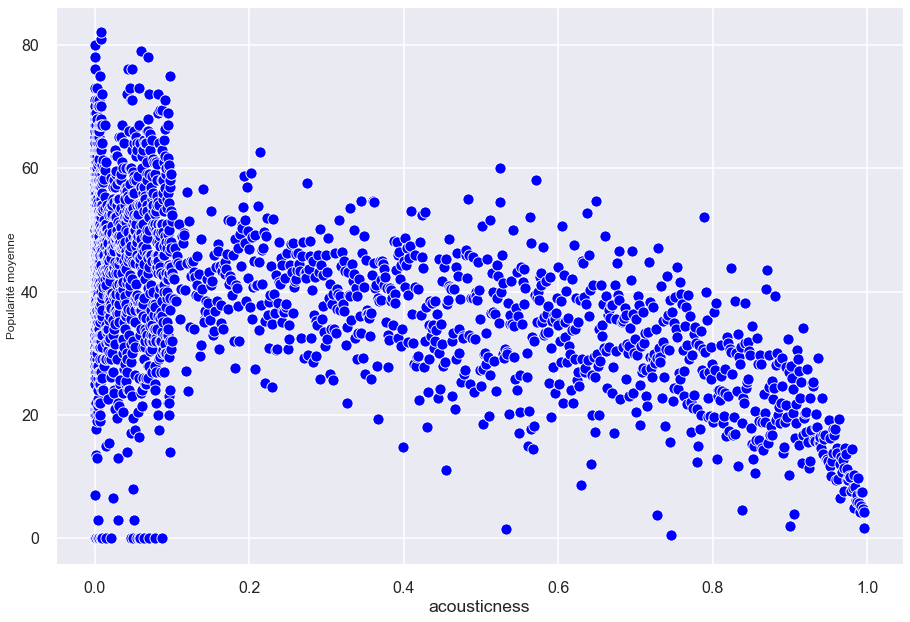

In [26]:
ax_data = spotify_data.groupby(
    'acousticness')['popularity'].mean().to_frame().reset_index()
sns.scatterplot(x=ax_data['acousticness'],
                y=ax_data['popularity'],
                color='blue')
#plt.title("Acousticité")
plt.ylabel('Popularité moyenne', fontsize=12)
save_fig('mean_popularity_by_acousticness')
plt.show()

<b>Danceability</b>

Saving figure mean_popularity_by_danceability


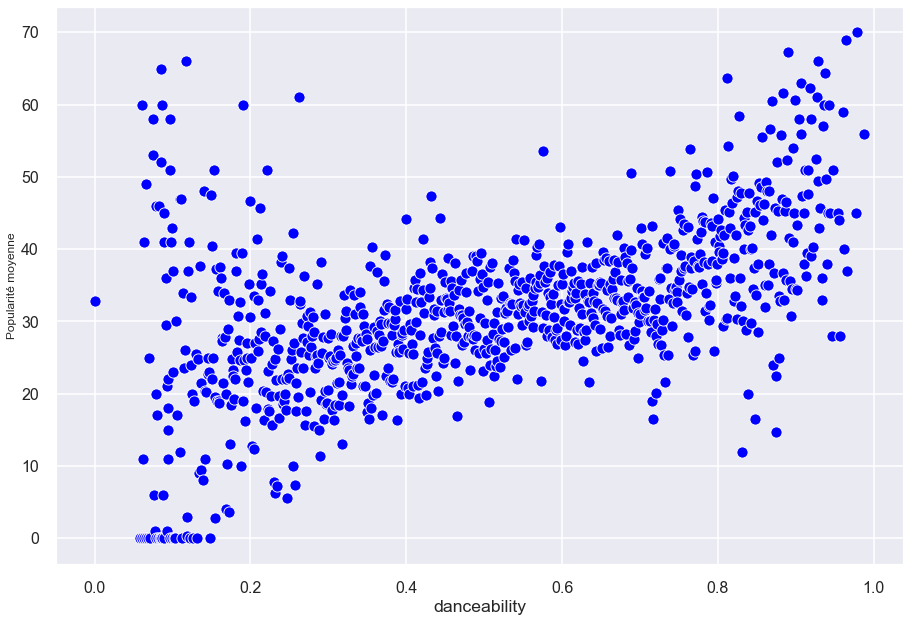

In [27]:
ax_data = spotify_data.groupby(
    'danceability')['popularity'].mean().to_frame().reset_index()
sns.scatterplot(x='danceability', y='popularity', data=ax_data, color='blue')
#plt.title('Dançabilité')
plt.ylabel('Popularité moyenne', fontsize=12)
save_fig('mean_popularity_by_danceability')
plt.show()

<b>Duration</b>

On convertit la durée des chansons en minutes pour en tirer plus d'informations.

In [28]:
spotify_data['duration'] = spotify_data['duration'] / 60000
spotify_data['duration'].describe()

count    10000.000000
mean         3.786918
std          1.874281
min          0.099850
25%          2.817783
50%          3.442158
75%          4.328883
max         45.053783
Name: duration, dtype: float64

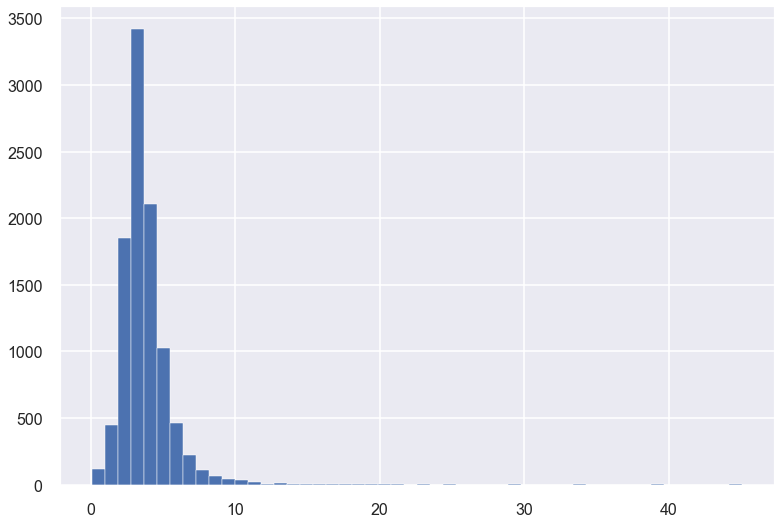

In [29]:
spotify_data['duration'].hist(bins=50)
plt.show()

On voit que la chanson la plus longue dans le jeu de données dure 45 minutes, donc on choisit de séparer les chansons longues de chansons courtes au seuil de 8 minutes pour mieux voir les durées.

In [30]:
long_songs = spotify_data.loc[spotify_data['duration'] > 8]
short_songs = spotify_data.loc[spotify_data['duration'] <= 8]

Saving figure hist_of_short_songs


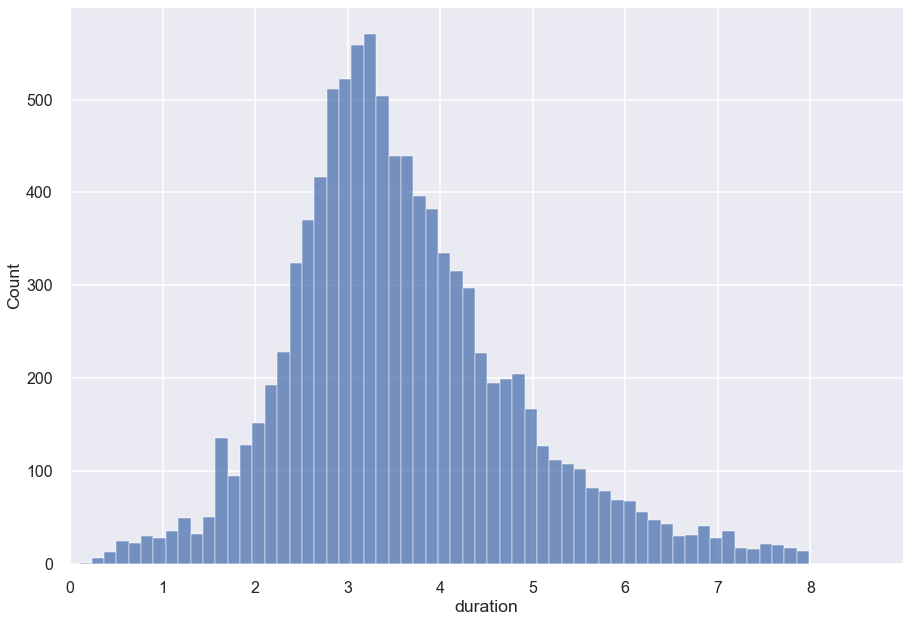

In [31]:
sns.histplot(short_songs['duration'], kde=False)
#plt.title(f'Chansons courtes (<=8 min) : {short_songs.shape[0]} chansons')
plt.xticks(range(0, 9, 1))
plt.xlim(0, 9)
save_fig('hist_of_short_songs')
plt.show()

Saving figure hist_of_long_songs


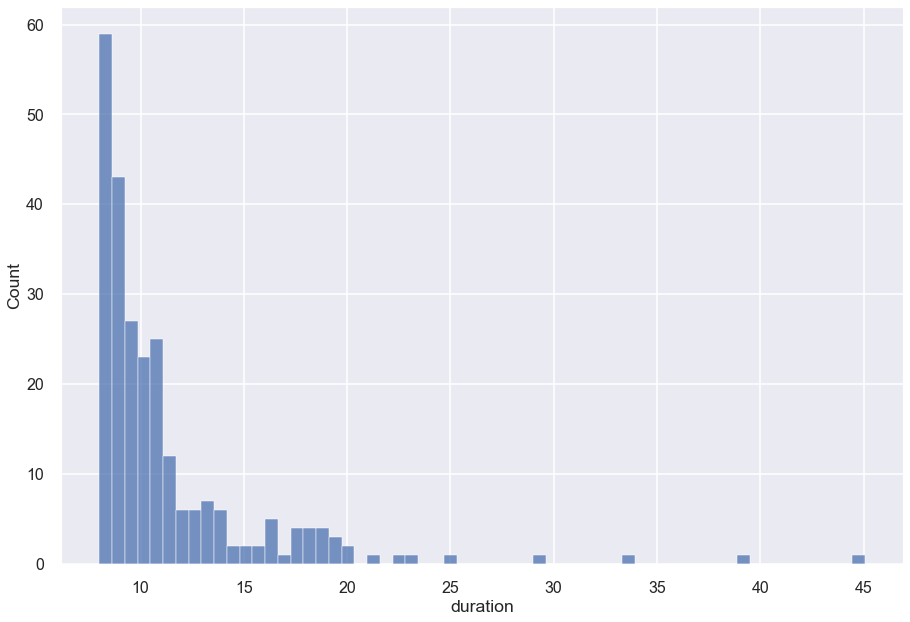

In [32]:
sns.histplot(long_songs['duration'], kde=False, bins=60)
#plt.title(f'Chansons longues (>8 min) : {long_songs.shape[0]} chansons')
save_fig('hist_of_long_songs')
plt.show()

Saving figure popularity_by_long_short_songs


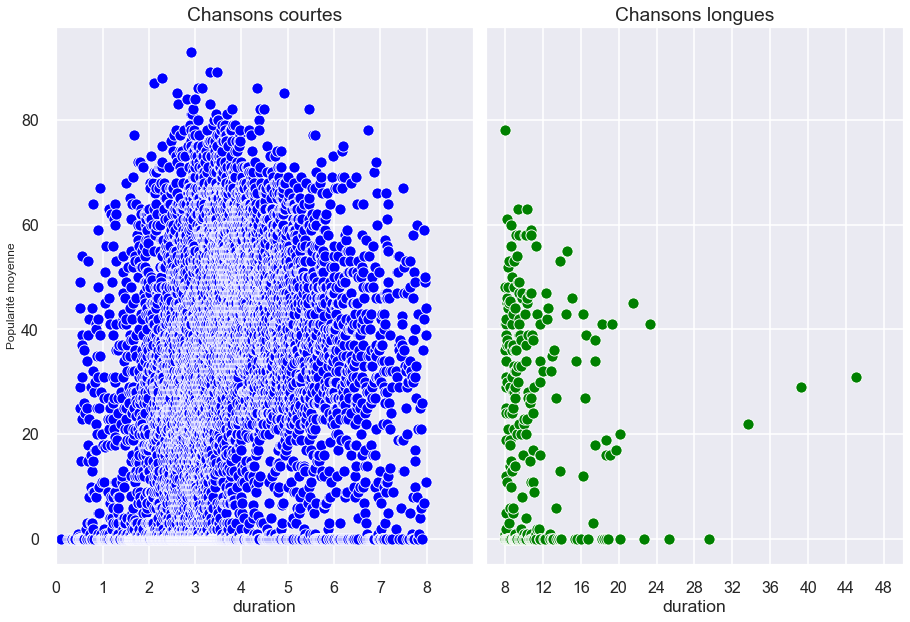

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1_data = short_songs.groupby(
    'duration')['popularity'].mean().to_frame().reset_index()
ax1 = sns.scatterplot(x='duration',
                      y='popularity',
                      data=ax1_data,
                      color='blue',
                      ax=ax1)
ax1.set_xticks(range(0, 9, 1))
ax1.set_xlim(0, 9)
ax1.set_title('Chansons courtes')

ax2_data = long_songs.groupby(
    'duration')['popularity'].mean().to_frame().reset_index()
ax2 = sns.scatterplot(x=ax2_data['duration'],
                      y=ax2_data['popularity'],
                      color='green',
                      ax=ax2)
ax2.set_xticks(range(8, 49, 4))
ax2.set_xlim(6, 50)
ax2.set_title('Chansons longues')
ax1.set_ylabel('Popularité moyenne', fontsize=12)
save_fig('popularity_by_long_short_songs')
plt.show()

<b>Energy</b>

Saving figure mean_popularity_by_energy


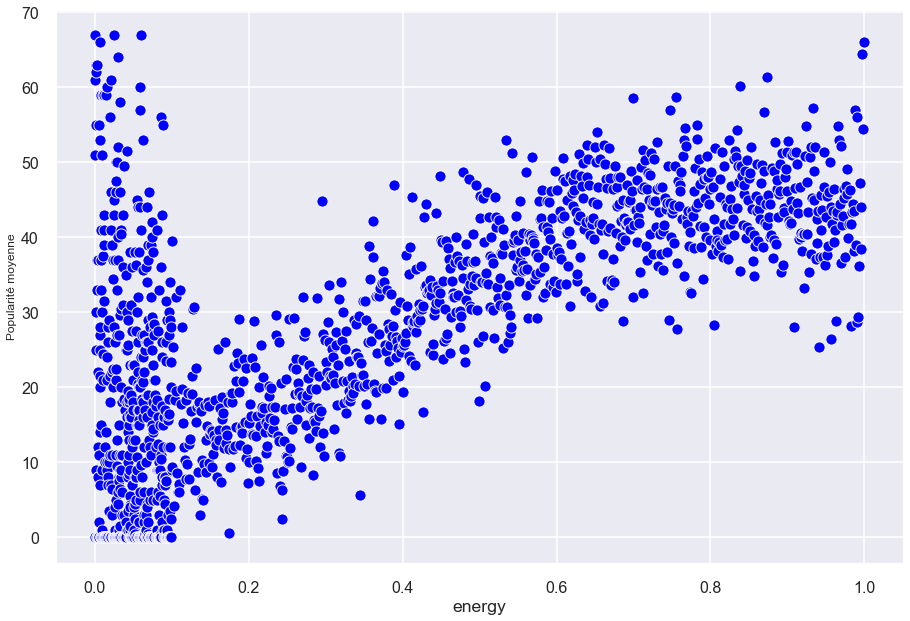

In [34]:
ax_data = spotify_data.groupby(
    'energy')['popularity'].mean().to_frame().reset_index()
sns.scatterplot(x='energy', y='popularity', data=ax_data, color='blue')
#plt.title('Énergie')
plt.ylabel('Popularité moyenne', fontsize=12)
save_fig('mean_popularity_by_energy')
plt.show()

<b>Instrumentalness</b>

In [35]:
spotify_data['instrumentalness'].describe()

count    10000.000000
mean         0.164947
std          0.313327
min          0.000000
25%          0.000000
50%          0.000174
75%          0.087100
max          1.000000
Name: instrumentalness, dtype: float64

In [36]:
spotify_data.loc[spotify_data['instrumentalness'] == 0].shape

(2806, 15)

On transformera la variable `instrumentalness` en trois sous-variables en raison de sa distribution inégale : il y a beaucoup de chansons ($2806$) ayant une valeur nulle d'instrumentalité, ce qui ne correspond pas vraiment avec la réalité.

In [37]:
# sns.histplot(spotify_data['instrumentalness'], kde=False, bins=50)
# plt.vlines(0.1, ymin=0, ymax=7000, linestyles='dashed',
#            linewidths=1., color='grey')
# plt.vlines(0.95, ymin=0, ymax=7000, linestyles='dashed',
#            linewidths=1., color='grey')
# plt.annotate('1ère limite (0.10)', xy=(0.1, 6500),
#              xytext=(0.2, 6500),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('2ème limite (0.95)', xy=(0.95, 6500),
#              xytext=(0.7, 6500),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.show()

In [38]:
# ax_data = spotify_data.groupby(
#     'instrumentalness')['popularity'].mean().to_frame().reset_index()
# sns.scatterplot(x='instrumentalness', y='popularity',
#                 data=ax_data, color='blue')
# #plt.title('Instrumentalité')
# plt.ylabel('Popularité moyenne', fontsize=12)
# plt.tight_layout()
# plt.show()

In [39]:
# criteria = [
#     spotify_data['instrumentalness'].between(0, 0.1),
#     spotify_data['instrumentalness'].between(0.100001, 0.95),
#     spotify_data['instrumentalness'].between(0.950001, 1)
# ]

# values = np.arange(1, 4)
# spotify_data['instrumentalness_criteria'] = np.select(criteria, values, 0)

Puis on supprime la variable `instrumentalness`.

In [40]:
# del spotify_data['instrumentalness']

# spotify_data.head()

In [41]:
# plt.figure(figsize=(8, 6))
# sns.histplot(spotify_data['instrumentalness_criteria'], kde=False, bins=3)
# plt.xticks(np.arange(1, 4))
# plt.show()

In [42]:
# spotify_data['instrumentalness_criteria'].value_counts()

<b>Liveness</b>

Saving figure mean_popularity_by_liveness


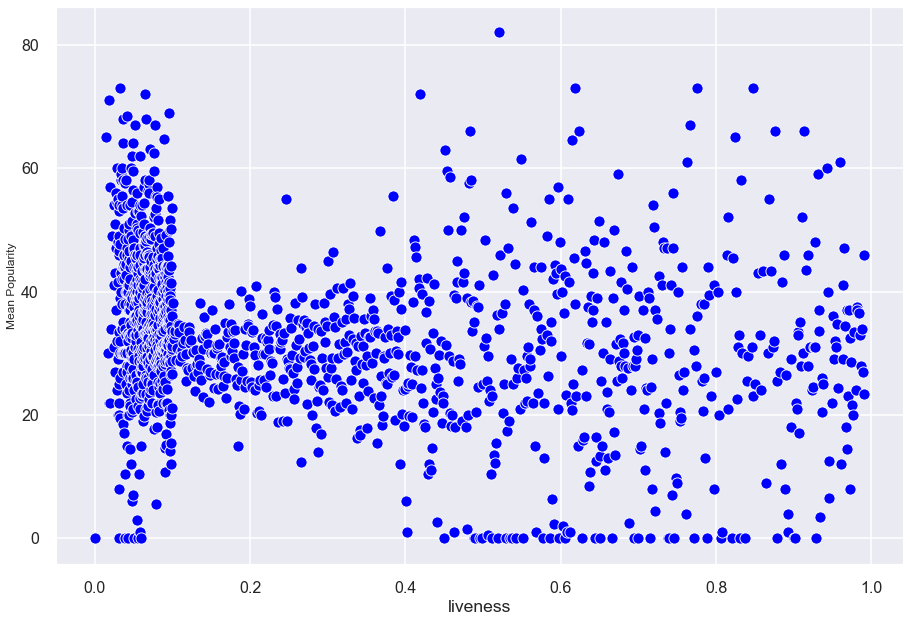

In [43]:
ax_data = spotify_data.groupby(
    'liveness')['popularity'].mean().to_frame().reset_index()
sns.scatterplot(x='liveness', y='popularity', data=ax_data, color='blue')
#plt.title('liveness')
plt.ylabel('Mean Popularity', fontsize=12)
save_fig('mean_popularity_by_liveness')
plt.show()

<b>Popularity</b> (variable à prédire)

Saving figure hist_of_popularity


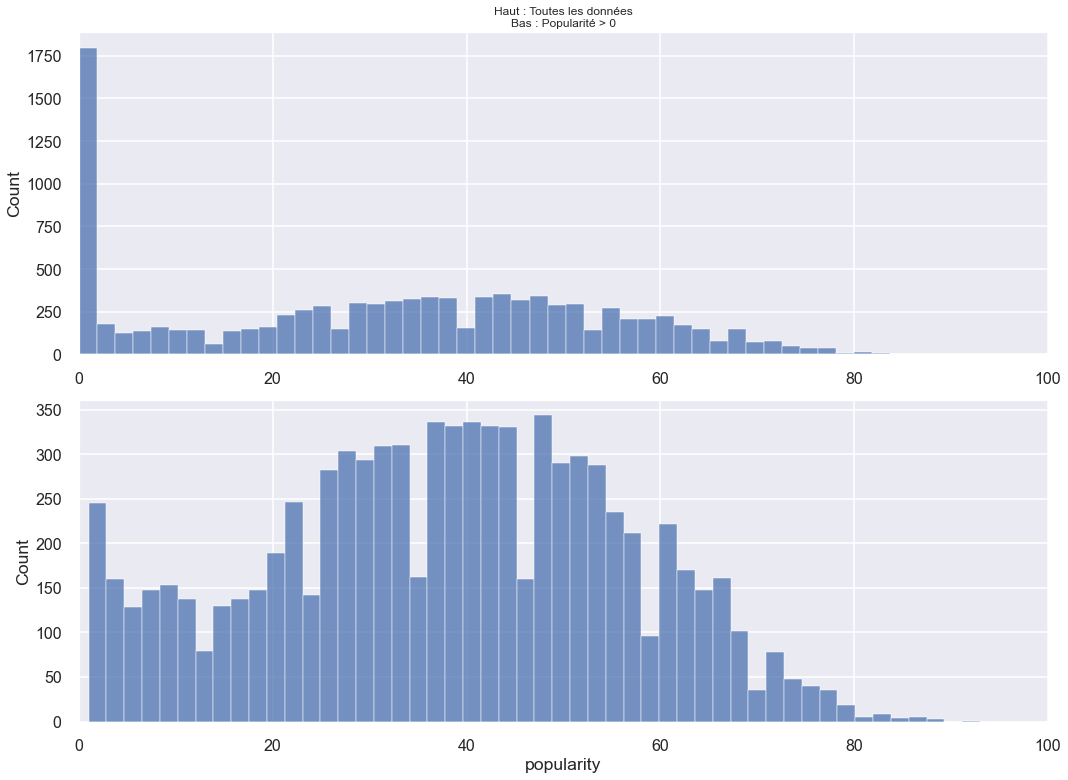

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11))
ax1 = sns.histplot(spotify_data['popularity'], ax=ax1, bins=50)
ax2 = sns.histplot(spotify_data.loc[spotify_data['popularity'] > 0, 'popularity'],
                   ax=ax2, bins=50)
ax1.set_xlim(0, 100)
ax2.set_xlim(0, 100)
ax1.set_xlabel('')
ax1.set_title('Haut : Toutes les données\nBas : Popularité > 0', fontsize=12)
save_fig('hist_of_popularity')
plt.show()

On voit qu'il y a un nombre important de chansons ayant 0 comme popularité. En effet ces chansons sont proches de l'extraction de la base des données et donc leur popularité n'avait pas encore été déterminée.

Saving figure mean_popularity_by_year


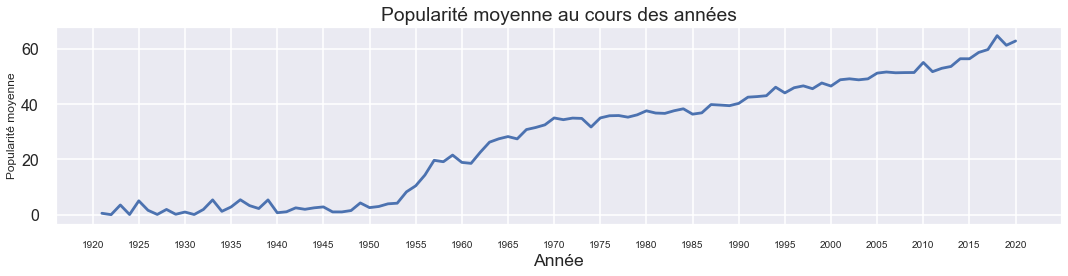

In [45]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = spotify_data.groupby('year')['popularity'].mean().plot()
ax.set_title('Popularité moyenne au cours des années')
ax.set_ylabel('Popularité moyenne', fontsize=12)
ax.set_xlabel('Année')
ax.xaxis.set_tick_params(labelsize=10)
ax.set_xticks(range(1920, 2021, 5))
save_fig('mean_popularity_by_year')
plt.show()

<b>Tempo</b>

Saving figure jointplot_of_tempo_popularity


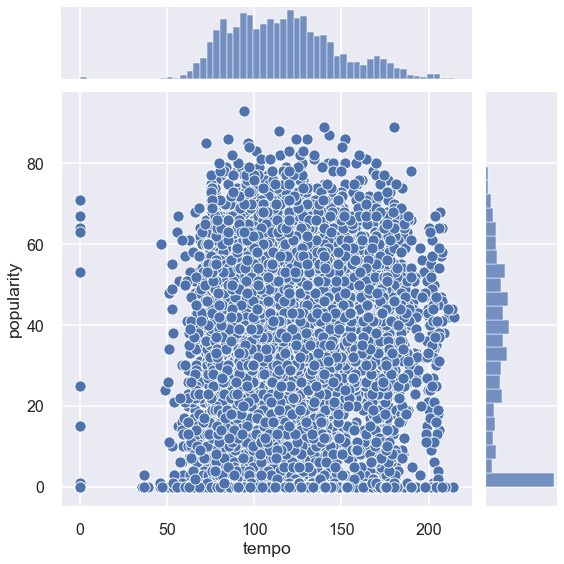

In [46]:
sns.jointplot(x='tempo', y='popularity', data=spotify_data, height=8)
save_fig('jointplot_of_tempo_popularity')
plt.show()

In [47]:
spotify_data.loc[spotify_data['tempo'] == 0].shape

(13, 15)

On voit qu'il y a 13 chansons pour lesquelles `tempo` vaut 0 ce qui n'est pas possible.

In [48]:
corrected_tempo = spotify_data.loc[spotify_data['tempo'] > 0]['tempo']
corrected_tempo.describe()

count    9987.000000
mean      117.017873
std        30.700602
min        35.374000
25%        93.685000
50%       114.555000
75%       135.482000
max       214.419000
Name: tempo, dtype: float64

Saving figure distribution_of_tempo


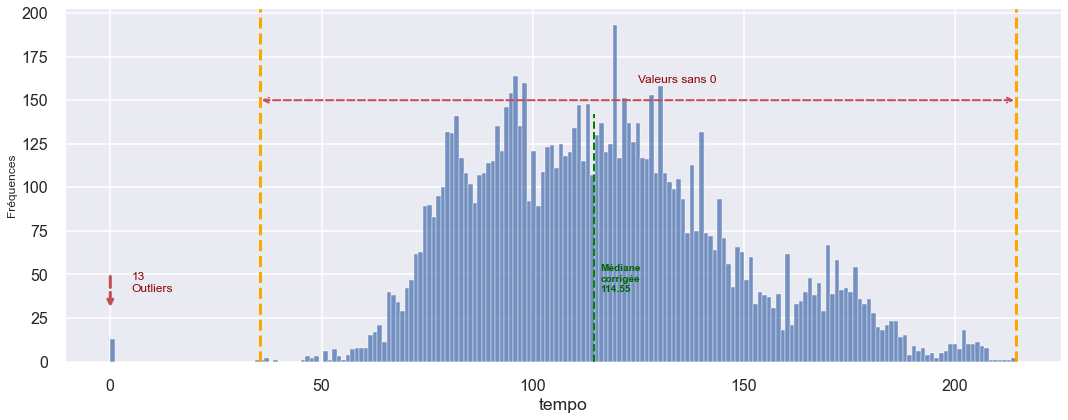

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.histplot(spotify_data['tempo'], bins=200, kde=False)
ax.set_ylabel('Fréquences', fontsize=12)

ax.text(s='13\nOutliers', x=5, y=40, fontdict={'size': 12, 'c': 'darkred'})
ax.text(s='Valeurs sans 0', x=125, y=160,
        fontdict={'size': 12, 'c': 'darkred'})
ax.text(s='Médiane\ncorrigée\n114.55', x=116, y=40,
        fontdict={'size': 10, 'c': 'darkgreen', 'weight': 'bold'})

ax.axvline(x=114.55, ymin=0, ymax=0.7, color='green',
           linestyle='dashed', linewidth=2)
ax.axvline(x=35.37, ymin=0, ymax=1, color='orange',
           linestyle='dashed', linewidth=3)
ax.axvline(x=214.42, ymin=0, ymax=1, color='orange',
           linestyle='dashed', linewidth=3)

ax.annotate("", xy=(35.37, 150), xytext=(214.42, 150),
            arrowprops=dict(arrowstyle="<->",
                            color='r',
                            linestyle='dashed',
                            linewidth=2))
ax.annotate("", xy=(0, 30), xytext=(0, 50),
            arrowprops=dict(arrowstyle="->",
                            color='r',
                            linestyle='dashed',
                            linewidth=3))

save_fig('distribution_of_tempo')
plt.show()

On replace les valeurs où `tempo` = 0 par la médiane dans la colonne.

In [50]:
median = spotify_data.loc[spotify_data["tempo"] > 0, "tempo"].median()
print(median)

spotify_data.replace(to_replace={"tempo": 0}, value=median, inplace=True)
spotify_data["tempo"].describe()

114.555


count    10000.000000
mean       117.014671
std         30.680767
min         35.374000
25%         93.713750
50%        114.555000
75%        135.470000
max        214.419000
Name: tempo, dtype: float64

<b>Year</b>

Saving figure jointplot_of_popularity_by_year


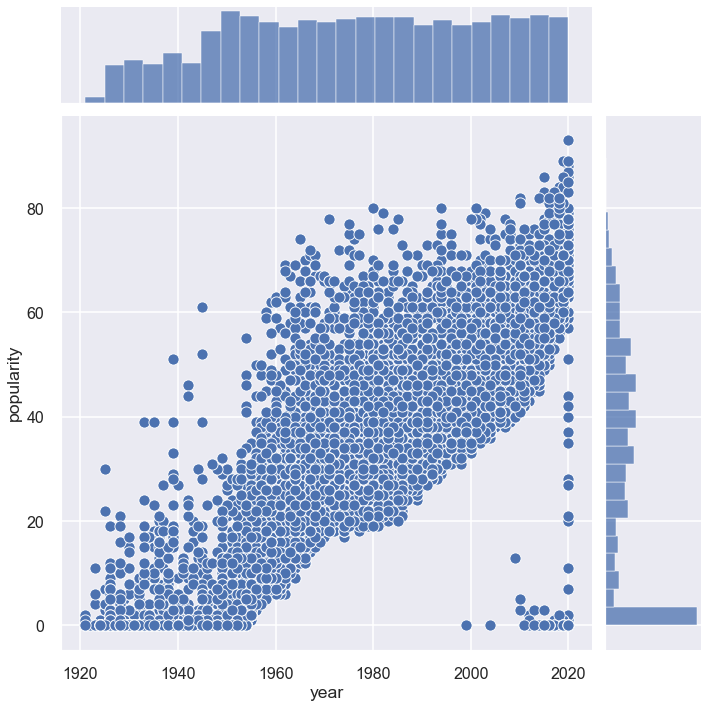

In [51]:
sns.jointplot(x='year', y='popularity', data=spotify_data, height=10)
#plt.suptitle("Joint plot de la popularité selon l'année de sortie", y=1.02)
save_fig("jointplot_of_popularity_by_year")
plt.show()

Quelques plots de corrélations :

In [52]:
# from pandas.plotting import scatter_matrix

# attributes = ["acousticness", "energy", "loudness", "popularity"]
# scatter_matrix(spotify_data[attributes],
#                alpha=0.2,
#                figsize=(20, 15),
#                diagonal='kde')
# plt.suptitle("Nuage de points de quelques variables", fontsize=20)
# save_fig("scatter_matrix_plot")
# plt.show()

Pour mieux visualiser la durée de la chanson, nous avons décidé de lui appliquer le logarithme naturel afin de réduire les valeurs, tout en gardant l'ordre de croissance.

In [53]:
# spotify_data["log_duration"] = np.log(spotify_data["duration"])
# spotify_data["log_duration"].hist(bins=50)
# plt.title("Log de la durée")
# save_fig("log_of_duration")
# plt.show()

In [54]:
# spotify_data["tempo_norm"] = (
#     spotify_data["tempo"] -
#     spotify_data["tempo"].mean()) / spotify_data["tempo"].std()
# spotify_data["tempo_norm"].hist(bins=50)
# plt.title("Variable 'tempo' normalisée")
# save_fig("scaled_tempo")
# plt.show()

In [55]:
# spotify_data["dance_norm"] = (
#     spotify_data["danceability"] -
#     spotify_data["danceability"].mean()) / spotify_data["danceability"].std()
# spotify_data["dance_norm"].hist(bins=50)
# plt.title("Variable 'danceability' normalisée")
# save_fig("scaled_danceability")
# plt.show()

In [56]:
# del spotify_data["duration"]
# del spotify_data["tempo"]
# del spotify_data["danceability"]
# spotify_data.head()

In [57]:
spotify_data.keys()

Index(['valence', 'year', 'acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'pop.class'],
      dtype='object')

Cette cellule prend assez de temps à s'exécuter.

In [58]:
# for i in ['key', 'mode']:
#     sns.pairplot(spotify_data, hue=i)
#     t = 'pairplot_of_data_by_' + i
#     save_fig(t)
#     plt.show()

In [59]:
# sns.pairplot(spotify_data)
# plt.suptitle("Pair plot des données", fontsize=20, y=1.02)
# save_fig("pairplot_of_dataset")
# plt.show()

# ACP

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

attributs = [
    feature for feature in spotify_data.keys()
    if feature not in data_qual.keys()
    and feature != 'popularity'
]
print(attributs)

['valence', 'year', 'acousticness', 'danceability', 'duration', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']


In [61]:
X_new = spotify_data[attributs]
X_scaled = scale(X_new)
pca = PCA(random_state=42)
C = pca.fit_transform(X_scaled)

In [62]:
x = np.arange(pca.explained_variance_.size)
cumsum = np.cumsum(pca.explained_variance_ratio_)
var_ratio = pca.explained_variance_ratio_

Saving figure explained_var_ratio_and_cumulative


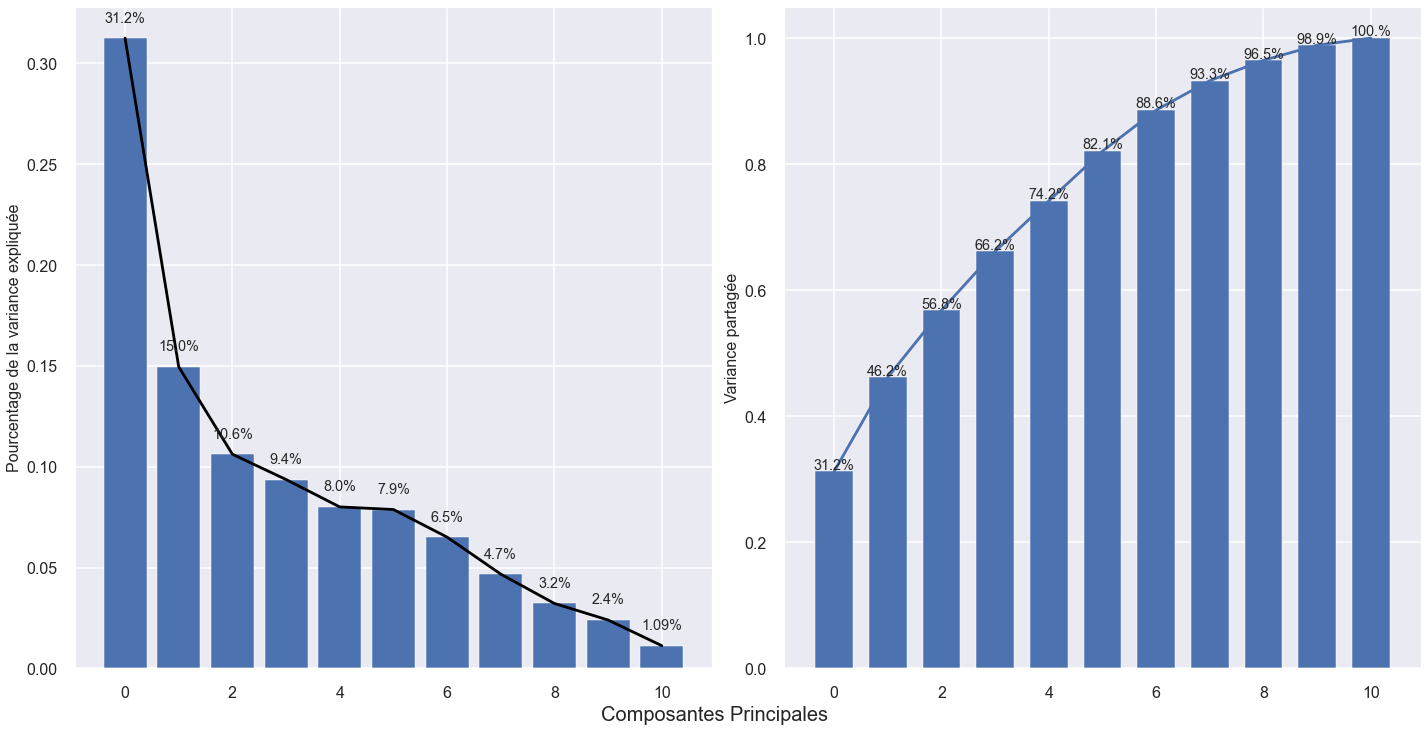

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

ax[0].bar(x, var_ratio)
ax[0].plot(var_ratio, color='black')
ax[0].set_ylabel("Pourcentage de la variance expliquée", fontsize=16)
#ax[0].set_title("Part de la variance expliquée", fontsize=15)

for p in ax[0].patches:
    text = str(np.round(p.get_height(), 3) * 100)[:4] + '%'
    ax[0].annotate(text=text,
                   xy=(p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
                   fontsize='large', ha='center', va='center')

ax[1].bar(x, cumsum, width=.7)
ax[1].plot(x, cumsum)
ax[1].set_ylabel("Variance partagée", fontsize=16)
#ax[1].set_title("Somme cumulée de la part de la variance", fontsize=15)

for p in ax[1].patches:
    text = str(np.round(p.get_height(), 3) * 100)[:4] + '%'
    ax[1].annotate(text=text,
                   xy=(p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
                   fontsize='large', ha='center', va='center')

fig.text(0.5, -0.01, "Composantes Principales", ha='center', fontsize=20)
#plt.suptitle("Analyse de la variance des composantes principales", fontsize=22)
save_fig("explained_var_ratio_and_cumulative")
plt.show()

Saving figure boxplot_of_variances


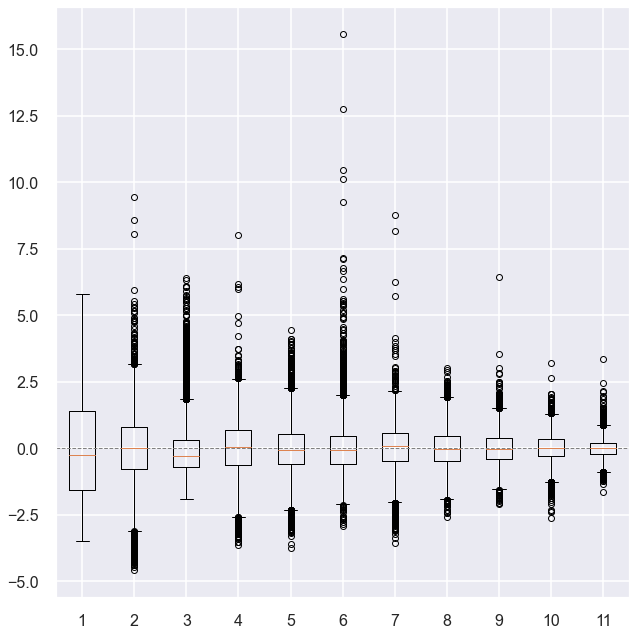

In [64]:
plt.figure(figsize=(9, 9))
plt.boxplot(C)
plt.axhline(color='grey', linewidth=1, linestyle='--')
#plt.title("Boxplot des variables de l'ACP")
save_fig("boxplot_of_variances")
plt.show()

1. Sélection de variables :
On sélectionne les 6 premières composantes principales.
Variance expliquée par les valeurs propres : 80% de variance expliquée à partir de 6 CP
On observe un coude sur le graphe des variances expliquées à partir de la 6e CP.
Boxplots : étendue des boxplots relativement stable à partir de la 5 ou 6e CP, la médiane des boxplots devient relativement identique.

Saving figure scatterplot_of_individuals


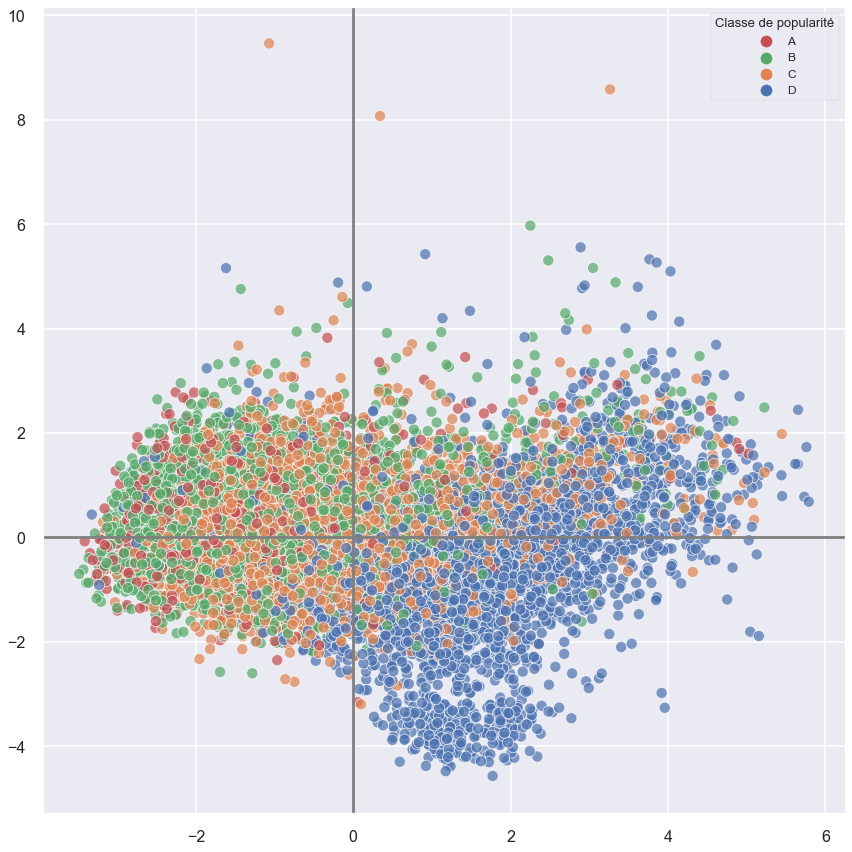

In [65]:
plt.figure(figsize=(12, 12))
sc = sns.scatterplot(x=C[:, 0], y=C[:, 1], hue='pop.class',
                     data=spotify_data, alpha=.7)
h, l = sc.get_legend_handles_labels()

plt.legend(title='Classe de popularité', handles=h[::-1], labels=l[::-1],
           title_fontsize=13, fontsize=12)
plt.axvline(color="grey")
plt.axhline(color="grey")
#plt.title("Nuage de points des individus de l'ACP")
save_fig("scatterplot_of_individuals")
plt.show()

2. Nuage de points des individus:
On observe 2 groupes distincts : 1 grand et un plus petit.

Saving figure pca_components_1_2


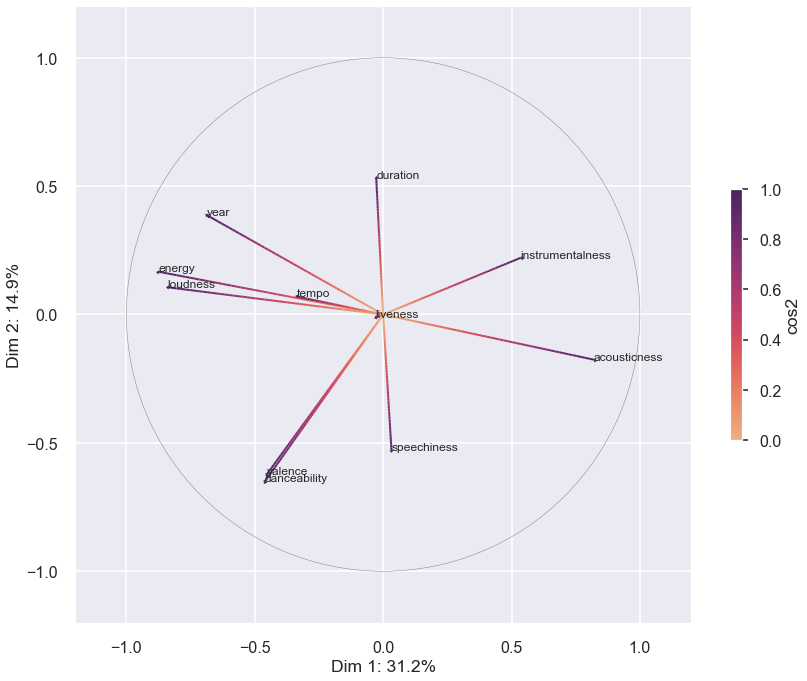

In [66]:
plot_corr_circle(X_new, pca, 1, 2)
save_fig("pca_components_1_2")
plt.show()

Saving figure pca_components_1_3


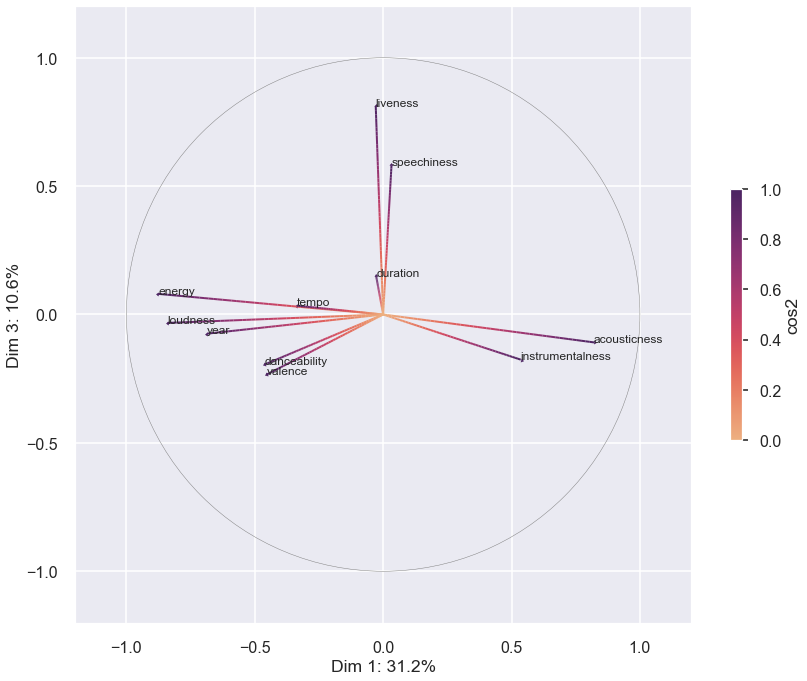

In [67]:
plot_corr_circle(X_new, pca, 1, 3)
save_fig("pca_components_1_3")
plt.show()

3. Cercle des correlations  (dim 1 et dim 2):
Axe des abscisses : Dimension 1
Axe des ordonnées : Dimension 2

Variables représentées par les flèches.

Speechiness : entièrement expliquée par la dimension 2.
Log_duration et speechiness sont très proches de l'axe des ordonnées : variables expliquées en majorité par la dimension 2.
Instrumentalness, accousticness, loudness: essetiellement expliquées par la dimension 1.

Accousticness et loudness : flèches sur le même axe. Variables inversement corrélées. En accord avec le graphe des corrélations.

Axe 2 : "divise" les flèches en 2 ?
A droite du graphe : dans les valeurs positives, on retrouve les chansons plus calmes / accoustiques / instrumentales
A gauche du graphe : dans les valeurs négatives , on retrouve les chansons plus "loud", dançantes

# Préparation des données

In [68]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

spotify_pop_class = spotify_data[["pop.class"]]
spotify_key = spotify_data[["key"]]

In [69]:
ordinal_encoder = OrdinalEncoder(dtype=np.int32)

spotify_pop_class_encoded = ordinal_encoder.fit_transform(spotify_pop_class)
spotify_pop_class_encoded = np.reshape(spotify_pop_class_encoded,
                                       spotify_data.shape[0])
print(spotify_pop_class_encoded[:10])

[2 1 0 2 2 0 1 1 0 1]


In [70]:
label_encoder = LabelEncoder()

spotify_key_encoded = label_encoder.fit_transform(spotify_key.values.ravel())
print(spotify_key_encoded[:10])

[ 2  1  2  2 10  5 10  7  5  9]


In [71]:
spotify_data["key"] = spotify_key_encoded
spotify_data["pop.class"] = spotify_pop_class_encoded

In [72]:
features = [
    feature for feature in spotify_data.keys()
    if feature not in ['popularity', 'pop.class']
]
print(features)

['valence', 'year', 'acousticness', 'danceability', 'duration', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']


In [73]:
X = spotify_data[features]
y_class = spotify_data[["pop.class"]]
y_reg = spotify_data[["popularity"]]
y_class = y_class.values.ravel()
y_reg = y_reg.values.ravel()

In [74]:
X.head()

,valence,year,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
161704,0.647,1975,0.4490,0.376,4.980667,0.827,0.007880,2,0.466,-7.604,1,0.3990,170.475
168077,0.150,2008,0.8990,0.508,3.946667,0.169,0.000011,1,0.136,-11.332,1,0.0553,107.477
35922,0.423,2007,0.0185,0.470,5.018217,0.878,0.083900,2,0.276,-5.576,0,0.0377,150.093
135823,0.302,1995,0.0384,0.176,2.370000,0.980,0.552000,2,0.237,-3.154,1,0.0721,172.566
165395,0.828,1994,0.5310,0.705,3.130000,0.625,0.000008,10,0.348,-11.963,0,0.0639,97.831


In [75]:
print(y_reg[:5])
print(y_class[:15])

[25 42 65 36 38]
[2 1 0 2 2 0 1 1 0 1 3 1 2 3 3]


# Apprentissage

In [76]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [77]:
def get_NN_model(n_inputs, n_outputs, problem=None):
    '''Fonction pour créer un réseau de neuronnes'''
    model = keras.models.Sequential()
    
    model.add(keras.layers.Dense(100,
                                 input_dim=n_inputs,
                                 activation='relu'))
    
    model.add(keras.layers.Dense(150, activation='relu'))
    model.add(keras.layers.Dense(100, activation='relu'))
    
    if problem == 'regression':
        model.add(keras.layers.Dense(n_outputs,
                                     activation='linear'))

        model.compile(loss='mean_squared_error',
                      optimizer=keras.optimizers.SGD(lr=1e-3),
                      metrics=['accuracy'])
    
    elif problem == 'classification':
        model.add(keras.layers.Dense(n_outputs,
                                     activation='softmax'))

        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=keras.optimizers.SGD(lr=1e-3),
                      metrics=['accuracy'])
    
    return model

## Classification

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

model_accuracy_score = []

In [79]:
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.25, random_state=42
)

In [80]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Régression logistique

#### Multinomiale

In [81]:
param = [{
    "C": [0.5, 1, 5, 10, 12, 15, 30]
}]

LM = GridSearchCV(LogisticRegression(penalty="l1",
                                     solver='saga',
                                     multi_class='multinomial',
                                     max_iter=4000),
                  param, cv=10)
LM.fit(X_train_scaled, y_train_class)

print("Meilleur score = %f, Meilleur paramètre = %s" %
      (LM.best_score_, LM.best_params_))

Meilleur score = 0.713067, Meilleur paramètre = {'C': 1}


In [82]:
LM_Predict = LM.predict(X_test_scaled)
LM_Accuracy = accuracy_score(y_test_class, LM_Predict)
model_accuracy_score.append(LM_Accuracy)

print("Précision :" + str(LM_Accuracy))

Précision :0.7144


Saving figure confusion_matrix_of_LM


<Figure size 864x864 with 0 Axes>

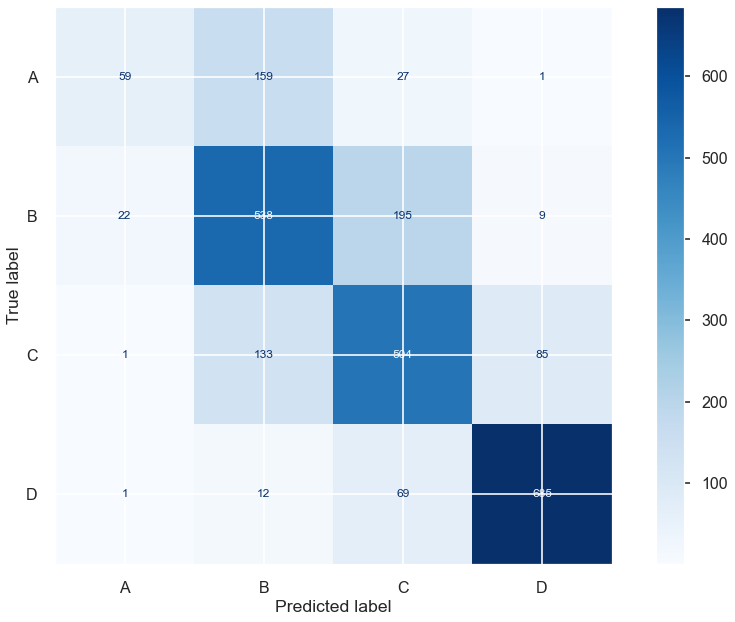

In [83]:
plot_cf_matrix(y_test_class, LM_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of LM")
save_fig("confusion_matrix_of_LM")
plt.show()

In [84]:
print(classification_report(y_test_class, LM_Predict))

              precision    recall  f1-score   support

           0       0.71      0.24      0.36       246
           1       0.64      0.70      0.67       764
           2       0.63      0.70      0.66       723
           3       0.88      0.89      0.89       767

    accuracy                           0.71      2500
   macro avg       0.72      0.63      0.64      2500
weighted avg       0.72      0.71      0.70      2500



#### OVR

In [85]:
param = [{
    "C": [0.5, 1, 5, 10, 12, 15, 30]
}]

LOVR = GridSearchCV(LogisticRegression(penalty="l1",
                                       solver='liblinear',
                                       multi_class='ovr'),
                    param, cv=10)
LOVR.fit(X_train_scaled, y_train_class)

print("Meilleur score = %f, Meilleur paramètre = %s" %
      (LOVR.best_score_, LOVR.best_params_))

Meilleur score = 0.681200, Meilleur paramètre = {'C': 0.5}


In [86]:
LOVR_Predict = LOVR.predict(X_test_scaled)
LOVR_Accuracy = accuracy_score(y_test_class, LOVR_Predict)
model_accuracy_score.append(LOVR_Accuracy)

print("Précision :" + str(LOVR_Accuracy))

Précision :0.6824


Saving figure confusion_matrix_of_LOVR


<Figure size 864x864 with 0 Axes>

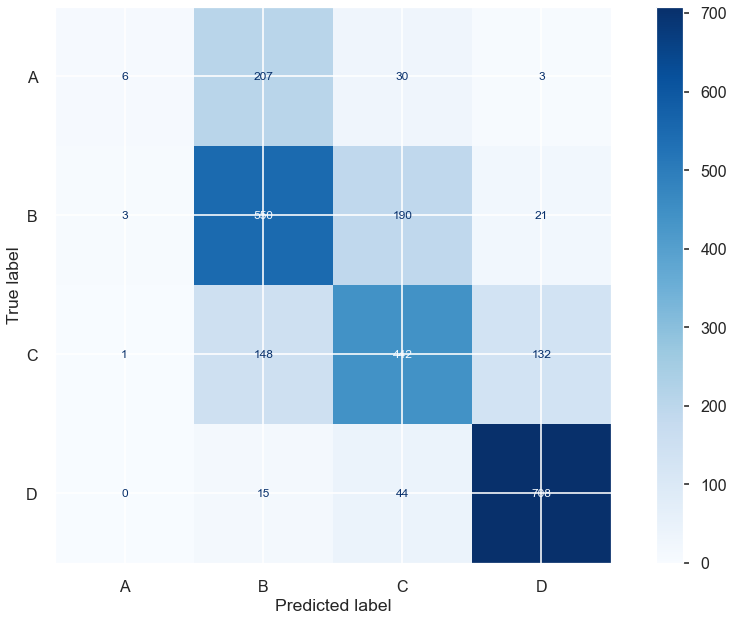

In [87]:
plot_cf_matrix(y_test_class, LOVR_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of LOVR")
save_fig("confusion_matrix_of_LOVR")
plt.show()

In [88]:
print(classification_report(y_test_class, LOVR_Predict))

              precision    recall  f1-score   support

           0       0.60      0.02      0.05       246
           1       0.60      0.72      0.65       764
           2       0.63      0.61      0.62       723
           3       0.82      0.92      0.87       767

    accuracy                           0.68      2500
   macro avg       0.66      0.57      0.55      2500
weighted avg       0.67      0.68      0.65      2500



### Random Forest

In [89]:
#param=[{"n_estimators":np.arange(100,500,100),"max_features":list(range(2,10,1))}]
param = [{
    "max_features": list(range(2, 10))
}]

RFC_Model = GridSearchCV(RandomForestClassifier(n_estimators=500, n_jobs=-1),
                         param, cv=5, verbose=3)
RFC_Model.fit(X_train, y_train_class)

print("Meilleur score = %f, Meilleur paramètre = %s" %
      (RFC_Model.best_score_, RFC_Model.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................................max_features=2; total time=   9.5s
[CV 2/5] END .................................max_features=2; total time=   2.9s
[CV 3/5] END .................................max_features=2; total time=   2.0s
[CV 4/5] END .................................max_features=2; total time=   1.9s
[CV 5/5] END .................................max_features=2; total time=   1.3s
[CV 1/5] END .................................max_features=3; total time=   1.3s
[CV 2/5] END .................................max_features=3; total time=   1.4s
[CV 3/5] END .................................max_features=3; total time=   1.4s
[CV 4/5] END .................................max_features=3; total time=   1.7s
[CV 5/5] END .................................max_features=3; total time=   1.5s
[CV 1/5] END .................................max_features=4; total time=   1.7s
[CV 2/5] END .................................max

In [90]:
RFC_Predict = RFC_Model.predict(X_test)
RFC_Accuracy = accuracy_score(y_test_class, RFC_Predict)
model_accuracy_score.append(RFC_Accuracy)

print("Précision : " + str(RFC_Accuracy))

Précision : 0.7388


Saving figure confusion_matrix_of_RFC


<Figure size 864x864 with 0 Axes>

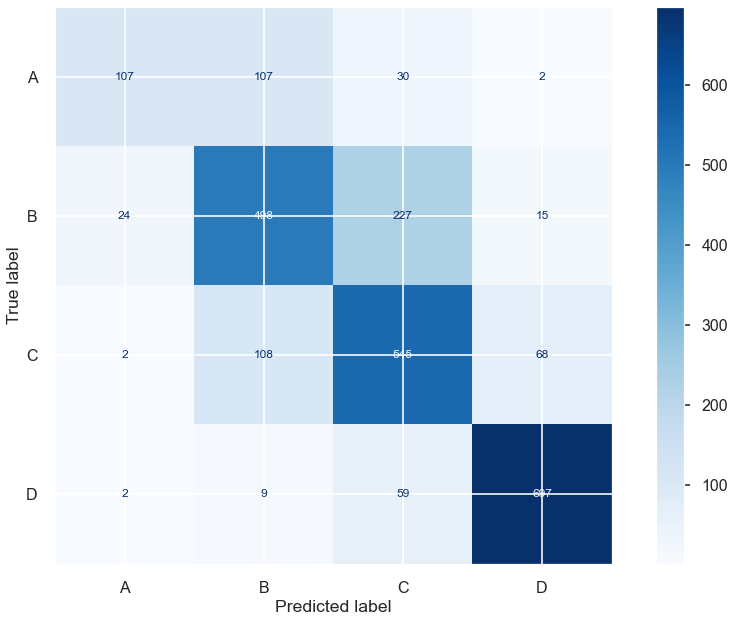

In [91]:
plot_cf_matrix(y_test_class, RFC_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of RFC")
save_fig("confusion_matrix_of_RFC")
plt.show()

In [92]:
# feature_df_rf = pd.DataFrame({
#     'Importance': RFC_Model.feature_importances_,
#     'Features': features
# })

# feature_df_rf.sort_values(by='Importance', ascending=False)

In [93]:
print(classification_report(y_test_class, RFC_Predict))

              precision    recall  f1-score   support

           0       0.79      0.43      0.56       246
           1       0.69      0.65      0.67       764
           2       0.63      0.75      0.69       723
           3       0.89      0.91      0.90       767

    accuracy                           0.74      2500
   macro avg       0.75      0.69      0.71      2500
weighted avg       0.75      0.74      0.74      2500



### Decision Trees

In [94]:
param = [{
    'min_samples_split': range(2, 203, 10),
    'max_features': [None, 'auto', 'sqrt', 'log2']
}]

DT_Model = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param, cv=5, verbose=3)
DT_Model.fit(X_train, y_train_class)

print("Meilleur score = %f, Meilleurs paramètres = %s" %
      (DT_Model.best_score_, DT_Model.best_params_))

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END .........max_features=None, min_samples_split=2; total time=   0.0s
[CV 2/5] END .........max_features=None, min_samples_split=2; total time=   0.0s
[CV 3/5] END .........max_features=None, min_samples_split=2; total time=   0.0s
[CV 4/5] END .........max_features=None, min_samples_split=2; total time=   0.0s
[CV 5/5] END .........max_features=None, min_samples_split=2; total time=   0.0s
[CV 1/5] END ........max_features=None, min_samples_split=12; total time=   0.0s
[CV 2/5] END ........max_features=None, min_samples_split=12; total time=   0.0s
[CV 3/5] END ........max_features=None, min_samples_split=12; total time=   0.0s
[CV 4/5] END ........max_features=None, min_samples_split=12; total time=   0.0s
[CV 5/5] END ........max_features=None, min_samples_split=12; total time=   0.0s
[CV 1/5] END ........max_features=None, min_samples_split=22; total time=   0.0s
[CV 2/5] END ........max_features=None, min_sam

[CV 2/5] END .......max_features=None, min_samples_split=202; total time=   0.0s
[CV 3/5] END .......max_features=None, min_samples_split=202; total time=   0.0s
[CV 4/5] END .......max_features=None, min_samples_split=202; total time=   0.0s
[CV 5/5] END .......max_features=None, min_samples_split=202; total time=   0.0s
[CV 1/5] END .........max_features=auto, min_samples_split=2; total time=   0.0s
[CV 2/5] END .........max_features=auto, min_samples_split=2; total time=   0.0s
[CV 3/5] END .........max_features=auto, min_samples_split=2; total time=   0.0s
[CV 4/5] END .........max_features=auto, min_samples_split=2; total time=   0.0s
[CV 5/5] END .........max_features=auto, min_samples_split=2; total time=   0.0s
[CV 1/5] END ........max_features=auto, min_samples_split=12; total time=   0.0s
[CV 2/5] END ........max_features=auto, min_samples_split=12; total time=   0.0s
[CV 3/5] END ........max_features=auto, min_samples_split=12; total time=   0.0s
[CV 4/5] END ........max_fea

[CV 1/5] END .......max_features=auto, min_samples_split=202; total time=   0.0s
[CV 2/5] END .......max_features=auto, min_samples_split=202; total time=   0.0s
[CV 3/5] END .......max_features=auto, min_samples_split=202; total time=   0.0s
[CV 4/5] END .......max_features=auto, min_samples_split=202; total time=   0.0s
[CV 5/5] END .......max_features=auto, min_samples_split=202; total time=   0.0s
[CV 1/5] END .........max_features=sqrt, min_samples_split=2; total time=   0.0s
[CV 2/5] END .........max_features=sqrt, min_samples_split=2; total time=   0.0s
[CV 3/5] END .........max_features=sqrt, min_samples_split=2; total time=   0.0s
[CV 4/5] END .........max_features=sqrt, min_samples_split=2; total time=   0.0s
[CV 5/5] END .........max_features=sqrt, min_samples_split=2; total time=   0.0s
[CV 1/5] END ........max_features=sqrt, min_samples_split=12; total time=   0.0s
[CV 2/5] END ........max_features=sqrt, min_samples_split=12; total time=   0.0s
[CV 3/5] END ........max_fea

[CV 1/5] END .........max_features=log2, min_samples_split=2; total time=   0.0s
[CV 2/5] END .........max_features=log2, min_samples_split=2; total time=   0.0s
[CV 3/5] END .........max_features=log2, min_samples_split=2; total time=   0.0s
[CV 4/5] END .........max_features=log2, min_samples_split=2; total time=   0.0s
[CV 5/5] END .........max_features=log2, min_samples_split=2; total time=   0.0s
[CV 1/5] END ........max_features=log2, min_samples_split=12; total time=   0.0s
[CV 2/5] END ........max_features=log2, min_samples_split=12; total time=   0.0s
[CV 3/5] END ........max_features=log2, min_samples_split=12; total time=   0.0s
[CV 4/5] END ........max_features=log2, min_samples_split=12; total time=   0.0s
[CV 5/5] END ........max_features=log2, min_samples_split=12; total time=   0.0s
[CV 1/5] END ........max_features=log2, min_samples_split=22; total time=   0.0s
[CV 2/5] END ........max_features=log2, min_samples_split=22; total time=   0.0s
[CV 3/5] END ........max_fea

In [95]:
DT_Predict = DT_Model.predict(X_test)
DT_Accuracy = accuracy_score(y_test_class, DT_Predict)
model_accuracy_score.append(DT_Accuracy)

print("Précision : " + str(DT_Accuracy))

Précision : 0.7312


Saving figure confusion_matrix_of_DT


<Figure size 864x864 with 0 Axes>

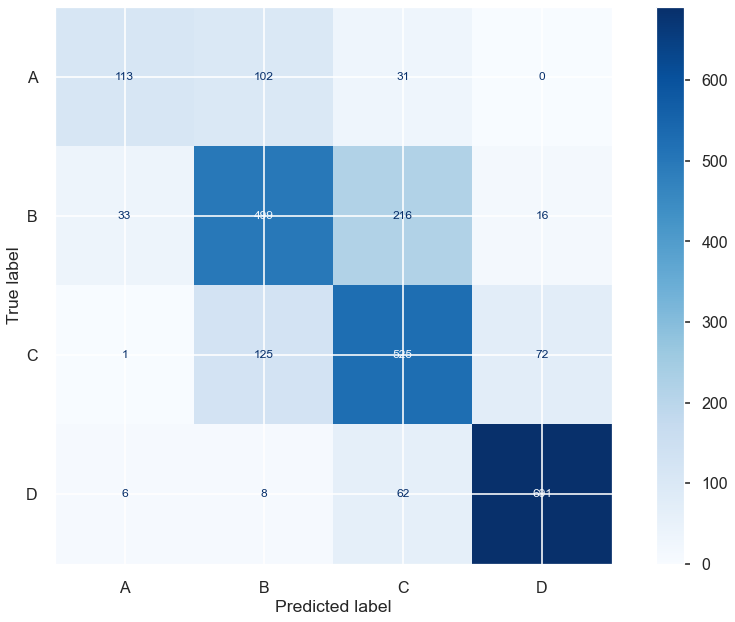

In [96]:
plot_cf_matrix(y_test_class, DT_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of Decision Trees")
save_fig("confusion_matrix_of_DT")
plt.show()

In [97]:
# feature_df_dt = pd.DataFrame({
#     'Importance': DT_Model.feature_importances_,
#     'Features': features
# })

# feature_df_dt.sort_values(by='Importance', ascending=False)

In [98]:
print(classification_report(y_test_class, DT_Predict))

              precision    recall  f1-score   support

           0       0.74      0.46      0.57       246
           1       0.68      0.65      0.67       764
           2       0.63      0.73      0.67       723
           3       0.89      0.90      0.89       767

    accuracy                           0.73      2500
   macro avg       0.73      0.68      0.70      2500
weighted avg       0.73      0.73      0.73      2500



### LinearSVC

#### OVR

In [99]:
LSVC_Model = LinearSVC(multi_class='ovr', max_iter=5000, random_state=100)
LSVC_Model.fit(X_train_scaled, y_train_class)

C:\Users\Joan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=5000, random_state=100)

In [100]:
LSVC_Predict = LSVC_Model.predict(X_test_scaled)
LSVC_Accuracy = accuracy_score(y_test_class, LSVC_Predict)
model_accuracy_score.append(LSVC_Accuracy)

print("Précision : " + str(LSVC_Accuracy))

Précision : 0.6668


Saving figure confusion_matrix_of_LSVC_OVR


<Figure size 864x864 with 0 Axes>

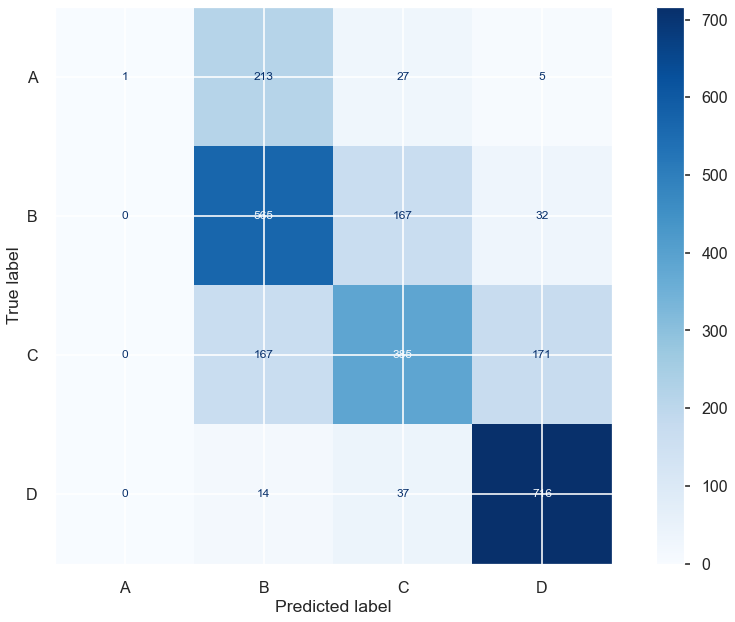

In [101]:
plot_cf_matrix(y_test_class, LSVC_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of LSVC OVR")
save_fig("confusion_matrix_of_LSVC_OVR")
plt.show()

In [102]:
print(classification_report(y_test_class, LSVC_Predict))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       246
           1       0.59      0.74      0.66       764
           2       0.62      0.53      0.58       723
           3       0.77      0.93      0.85       767

    accuracy                           0.67      2500
   macro avg       0.75      0.55      0.52      2500
weighted avg       0.70      0.67      0.63      2500



#### Crammer-Singer

In [103]:
LSVC_CS_Model = LinearSVC(multi_class='crammer_singer',
                       max_iter=5000,
                       random_state=42)
LSVC_CS_Model.fit(X_train_scaled, y_train_class)

C:\Users\Joan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=5000, multi_class='crammer_singer', random_state=42)

#### LSVC_CS_Predict = LSVC_CS_Model.predict(X_test_scaled)
LSVC_CS_Accuracy = accuracy_score(y_test_class, LSVC_CS_Predict)
model_accuracy_score.append(LSVC_CS_Accuracy)

print("Précision : " + str(LSVC_CS_Accuracy))

Saving figure confusion_matrix_of_LSVC_CS


<Figure size 864x864 with 0 Axes>

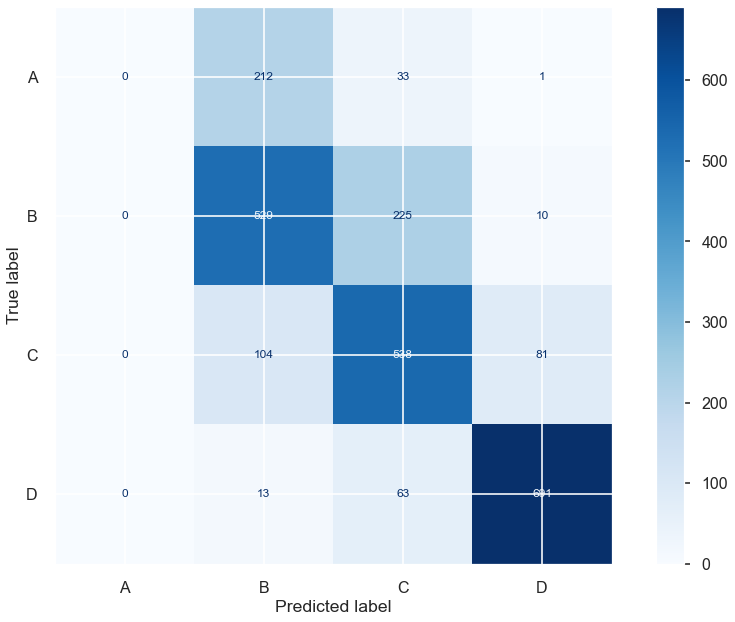

In [105]:
plot_cf_matrix(y_test_class, LSVC_CS_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of LSVC C-S")
save_fig("confusion_matrix_of_LSVC_CS")
plt.show()

In [106]:
print(classification_report(y_test_class, LSVC_Predict, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       246
           1       0.59      0.74      0.66       764
           2       0.62      0.53      0.58       723
           3       0.77      0.93      0.85       767

    accuracy                           0.67      2500
   macro avg       0.75      0.55      0.52      2500
weighted avg       0.70      0.67      0.63      2500



### SVC

In [107]:
param = [{
    "C": [0.5, 1., 2., 5., 10., 15., 30.]
}]
SVC_Model = GridSearchCV(SVC(), param, cv=5, verbose=3)
SVC_Model.fit(X_train_scaled, y_train_class)

print("Meilleur score = %f, Meilleur paramètre = %s" %
      (SVC_Model.best_score_, SVC_Model.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ..........................................C=0.5; total time=   2.4s
[CV 2/5] END ..........................................C=0.5; total time=   2.3s
[CV 3/5] END ..........................................C=0.5; total time=   2.0s
[CV 4/5] END ..........................................C=0.5; total time=   1.7s
[CV 5/5] END ..........................................C=0.5; total time=   1.8s
[CV 1/5] END ..........................................C=1.0; total time=   2.3s
[CV 2/5] END ..........................................C=1.0; total time=   2.5s
[CV 3/5] END ..........................................C=1.0; total time=   2.3s
[CV 4/5] END ..........................................C=1.0; total time=   2.4s
[CV 5/5] END ..........................................C=1.0; total time=   2.6s
[CV 1/5] END ..........................................C=2.0; total time=   2.2s
[CV 2/5] END ....................................

In [108]:
SVC_Predict = SVC_Model.predict(X_test_scaled)
SVC_Accuracy = accuracy_score(y_test_class, SVC_Predict)
model_accuracy_score.append(SVC_Accuracy)

print("Précision :" + str(SVC_Accuracy))

Précision :0.7056


Saving figure confusion_matrix_of_SVC


<Figure size 864x864 with 0 Axes>

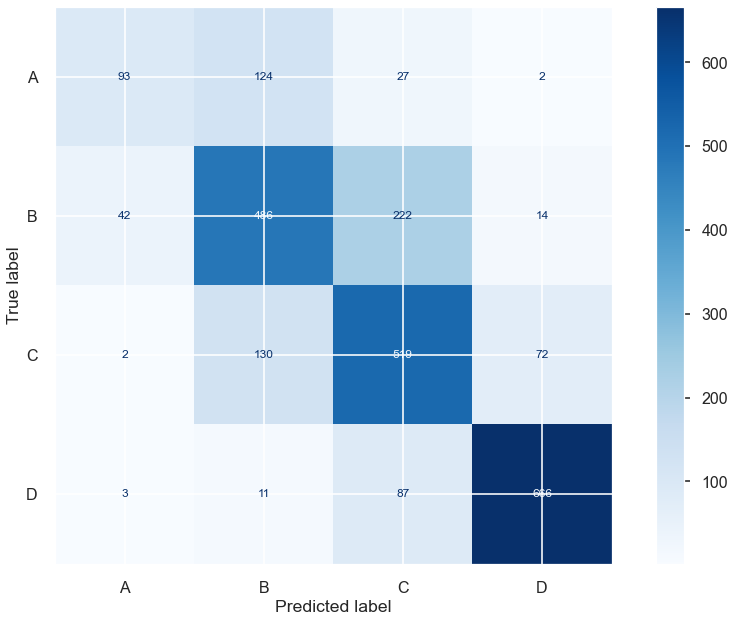

In [109]:
plot_cf_matrix(y_test_class, SVC_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of LOVR")
save_fig("confusion_matrix_of_SVC")
plt.show()

In [110]:
print(classification_report(y_test_class, SVC_Predict))

              precision    recall  f1-score   support

           0       0.66      0.38      0.48       246
           1       0.65      0.64      0.64       764
           2       0.61      0.72      0.66       723
           3       0.88      0.87      0.88       767

    accuracy                           0.71      2500
   macro avg       0.70      0.65      0.66      2500
weighted avg       0.71      0.71      0.70      2500



### Réseaux de neurones

In [111]:
# n_hidden = 10
# n_features = 10
# n_classes = 4
# keras_model = Sequential()
# keras_model.add(Dense(n_hidden, input_dim=n_features, activation='sigmoid'))
# keras_model.add(Dense(n_classes, activation='softmax'))

# keras_model.compile(optimizer=SGD(lr=3),
#                     loss='categorical_crossentropy',
#                     metrics=['accuracy'])
# history = keras_model.fit(X_train, y_train, validation_data=(X_valid, y_valid))

In [112]:
n_inputs, n_outputs = X_train.shape[1], 4
model = get_NN_model(n_inputs, n_outputs, 'classification')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1400      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 32,054
Trainable params: 32,054
Non-trainable params: 0
_________________________________________________________________


In [113]:
MM_scaler = MinMaxScaler()

X_train_scaled = MM_scaler.fit_transform(X_train)
X_test_scaled = MM_scaler.transform(X_test)

In [114]:
history = model.fit(X_train_scaled, y_train_class, epochs=200, batch_size=30,
                    validation_data=(X_test_scaled, y_test_class), verbose=0)

Saving figure keras_learning_curves_plot_class


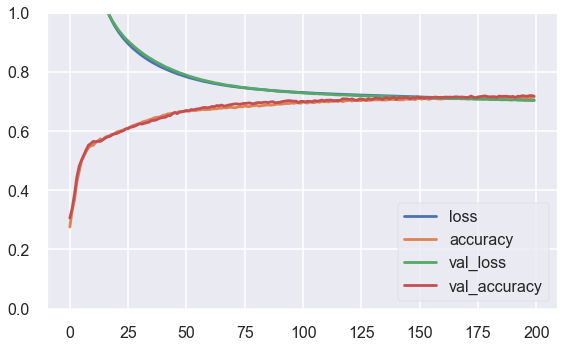

In [115]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)
save_fig("keras_learning_curves_plot_class")
plt.show()

In [116]:
NN_Predict = np.argmax(model.predict(X_test_scaled), axis=-1)
NN_Accuracy = accuracy_score(y_test_class, NN_Predict)
model_accuracy_score.append(NN_Accuracy)

print("Précision :" + str(NN_Accuracy))

Précision :0.718


Saving figure confusion_matrix_of_NN


<Figure size 864x864 with 0 Axes>

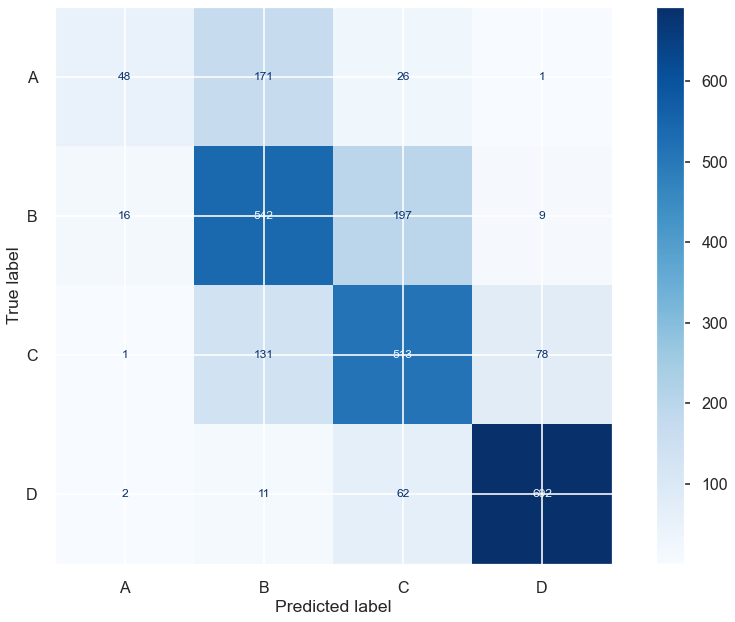

In [117]:
plot_cf_matrix(y_test_class, NN_Predict, cmap='Blues', draw_mosaic=False)
#plt.title("Confusion Matrix of NN")
save_fig("confusion_matrix_of_NN")
plt.show()

In [118]:
print(classification_report(y_test_class, NN_Predict))

              precision    recall  f1-score   support

           0       0.72      0.20      0.31       246
           1       0.63      0.71      0.67       764
           2       0.64      0.71      0.67       723
           3       0.89      0.90      0.89       767

    accuracy                           0.72      2500
   macro avg       0.72      0.63      0.64      2500
weighted avg       0.72      0.72      0.70      2500



In [119]:
model_performance_accuracy = pd.DataFrame({
    'Model': [
        'Logistic Regression', 'LOVR', 'Random Forest Classifier',
        'Decision Tree Classifier', 'Linear SVC', 'LSVC_CS Classifier',
        'SVC', 'Neural Network Classifier',
    ],
    'Accuracy': model_accuracy_score
})

model_performance_accuracy

,Model,Accuracy
0,Logistic Regression,0.7144
1,LOVR,0.6824
2,Random Forest Classifier,0.7388
3,Decision Tree Classifier,0.7312
4,Linear SVC,0.6668
5,LSVC_CS Classifier,0.7032
6,SVC,0.7056
7,Neural Network Classifier,0.7180


## Régression

In [120]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

reg_metrics = (mean_squared_error, r2_score, explained_variance_score)

In [121]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.25, random_state=42
)

In [122]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [123]:
mse_scores = []
r2_scores = []
evs_scores = []

### Régression linéaire

#### Sans pénalisation

In [124]:
LR_Model = LinearRegression()
LR_Model.fit(X_train, y_train_reg)
LR_Predict = LR_Model.predict(X_test)

In [125]:
mse_scores.append(mean_squared_error(y_test_reg, LR_Predict))
r2_scores.append(r2_score(y_test_reg, LR_Predict))
evs_scores.append(explained_variance_score(y_test_reg, LR_Predict))

Mean Squared Error : 115.0752
R2 Score : 0.75823
Explained Variance Score : 0.75826

Converting regression to classification...
Accuracy score: 0.6748 

Saving figure results_of_LR_predictions


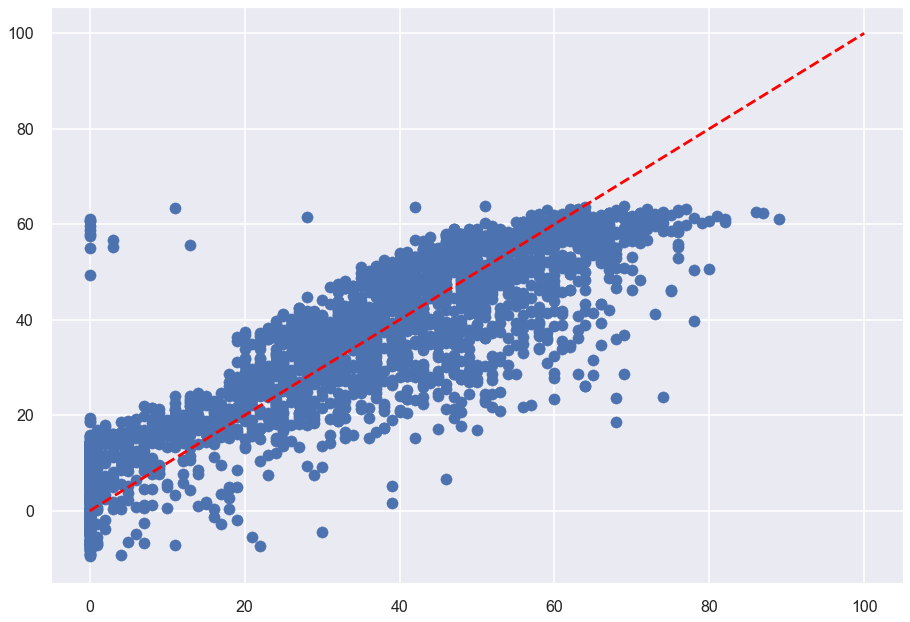

In [126]:
plot_results(reg_metrics, y_test_reg, y_test_class, LR_Predict)
#plt.title("Results of Linear Regression Predictions")
save_fig("results_of_LR_predictions")
plt.show()

#### Avec pénalisation Lasso

In [127]:
param = [{
    "alpha": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5, 2., 3.]
}]

LassoR_Model = GridSearchCV(Lasso(), param, cv=10)
LassoR_Model.fit(X_train, y_train_reg)
LassoR_Predict = LassoR_Model.predict(X_test)

# Paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (LassoR_Model.best_score_, LassoR_Model.best_params_))

Meilleur score = 0.742275, Meilleur paramètre = {'alpha': 0.01}


In [128]:
mse_scores.append(mean_squared_error(y_test_reg, LassoR_Predict))
r2_scores.append(r2_score(y_test_reg, LassoR_Predict))
evs_scores.append(explained_variance_score(y_test_reg, LassoR_Predict))

Mean Squared Error : 115.03054
R2 Score : 0.75833
Explained Variance Score : 0.75835

Converting regression to classification...
Accuracy score: 0.6736 

Saving figure results_of_Lasso_predictions


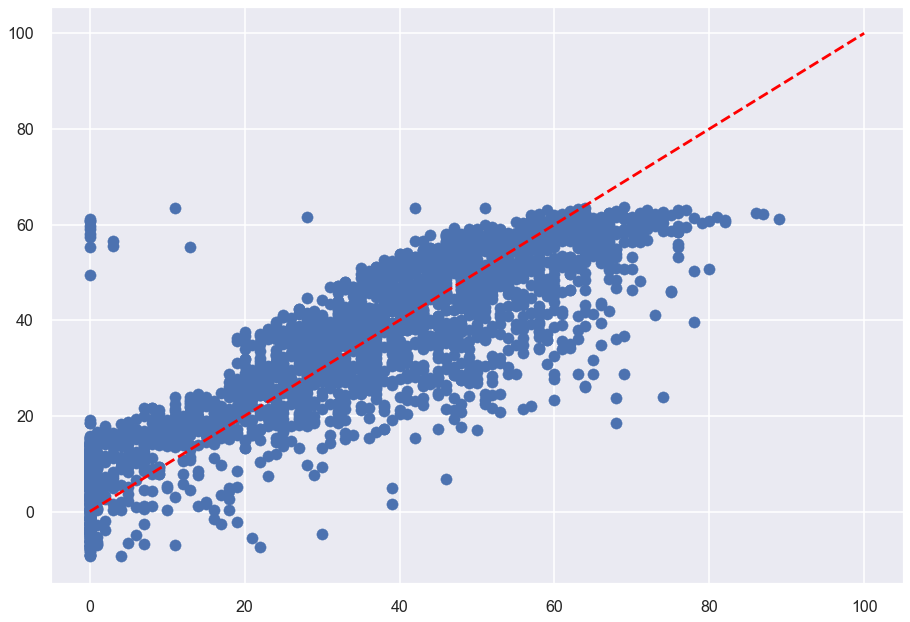

In [129]:
plot_results(reg_metrics, y_test_reg, y_test_class, LassoR_Predict)
#plt.title("Results of Linear Regression Predictions")
save_fig("results_of_Lasso_predictions")
plt.show()

#### Avec pénalisation Ridge

In [130]:
param = [{
    "alpha": [0.1, 0.2, 0.5, 1.0, 1.5, 2., 3., 5.]
}]

RidgeR_Model = GridSearchCV(Ridge(), param, cv=10)
RidgeR_Model.fit(X_train, y_train_reg)
RidgeR_Predict = RidgeR_Model.predict(X_test)

# Paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (RidgeR_Model.best_score_, RidgeR_Model.best_params_))

Meilleur score = 0.742322, Meilleur paramètre = {'alpha': 5.0}


In [131]:
mse_scores.append(mean_squared_error(y_test_reg, RidgeR_Predict))
r2_scores.append(r2_score(y_test_reg, RidgeR_Predict))
evs_scores.append(explained_variance_score(y_test_reg, RidgeR_Predict))

Mean Squared Error : 115.07773
R2 Score : 0.75823
Explained Variance Score : 0.75825

Converting regression to classification...
Accuracy score: 0.6744 

Saving figure results_of_Ridge_predictions


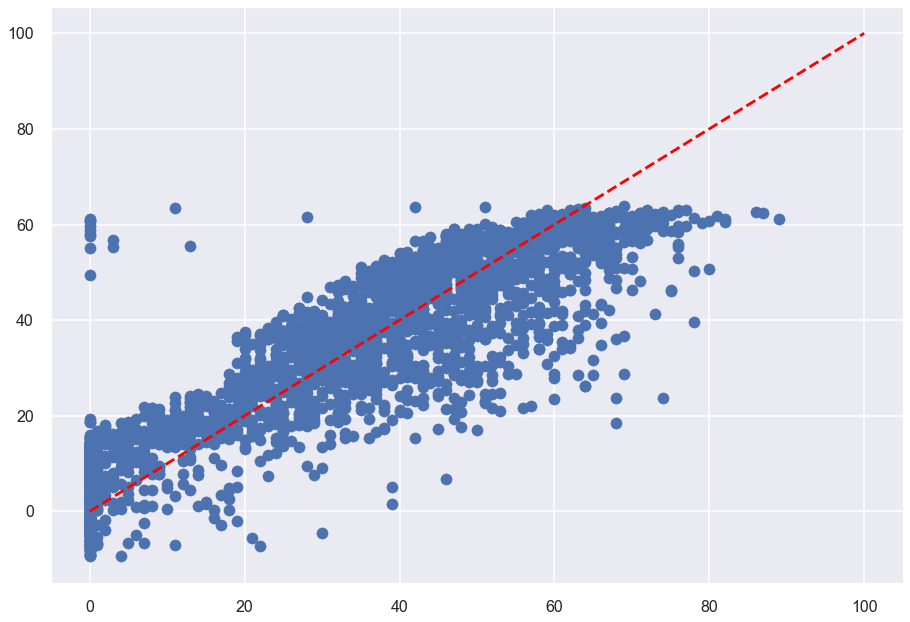

In [132]:
plot_results(reg_metrics, y_test_reg, y_test_class, RidgeR_Predict)
#plt.title("Results of Linear Regression Predictions")
save_fig("results_of_Ridge_predictions")
plt.show()

#### Avec pénalisation ElasticNet

In [133]:
param = [{
    "alpha": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5, 2., 3.]
}]

ENet_Model = GridSearchCV(ElasticNet(), param, cv=10)
ENet_Model.fit(X_train, y_train_reg)
ENet_Predict = ENet_Model.predict(X_test)

# Paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (ENet_Model.best_score_, ENet_Model.best_params_))

Meilleur score = 0.742194, Meilleur paramètre = {'alpha': 0.01}


In [134]:
mse_scores.append(mean_squared_error(y_test_reg, ENet_Predict))
r2_scores.append(r2_score(y_test_reg, ENet_Predict))
evs_scores.append(explained_variance_score(y_test_reg, ENet_Predict))

Mean Squared Error : 115.13567
R2 Score : 0.75811
Explained Variance Score : 0.75813

Converting regression to classification...
Accuracy score: 0.6748 

Saving figure results_of_EN_predictions


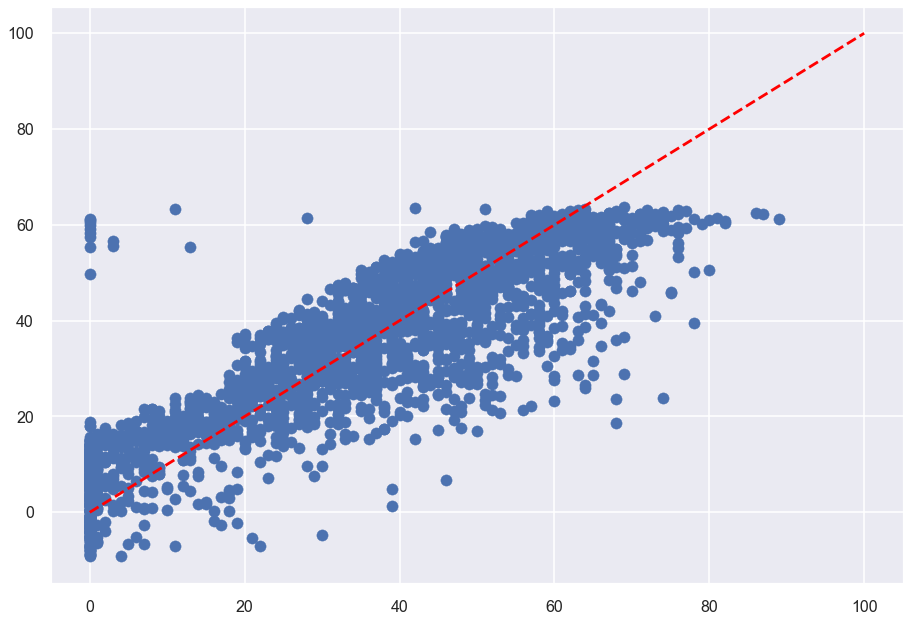

In [135]:
plot_results(reg_metrics, y_test_reg, y_test_class, ENet_Predict)
#plt.title("Results of Linear Regression Predictions")
save_fig("results_of_EN_predictions")
plt.show()

### Random Forest

Optimisation par validation croisée de la valeur de *max_features* et *min_samples_split*.

In [136]:
param = [{
    "max_features": list(range(2, 10)),
    "min_samples_split": list(range(2, 14))
}]

RF_Model = GridSearchCV(RandomForestRegressor(), param, cv=5, n_jobs=-1)
RF_Model.fit(X_train, y_train_reg)
RF_Predict = RF_Model.predict(X_test)

# Paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (RF_Model.best_score_, RF_Model.best_params_))

Meilleur score = 0.778382, Meilleur paramètre = {'max_features': 5, 'min_samples_split': 10}


In [137]:
mse_scores.append(mean_squared_error(y_test_reg, RF_Predict))
r2_scores.append(r2_score(y_test_reg, RF_Predict))
evs_scores.append(explained_variance_score(y_test_reg, RF_Predict))

Mean Squared Error : 98.11383
R2 Score : 0.79387
Explained Variance Score : 0.79387

Converting regression to classification...
Accuracy score: 0.7184 

Saving figure results_of_RF_predictions


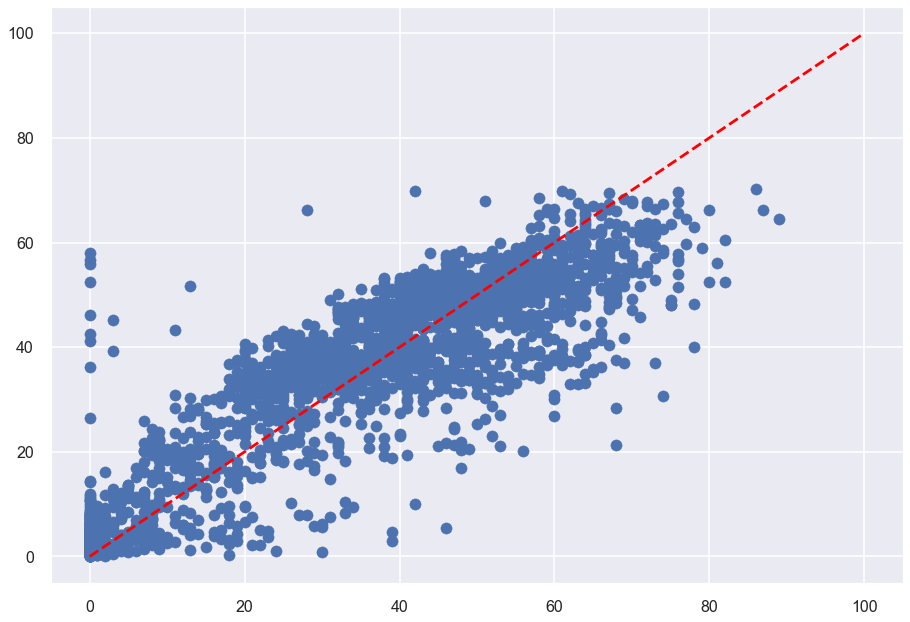

In [138]:
plot_results(reg_metrics, y_test_reg, y_test_class, RF_Predict)
#plt.title("Results of Random Forest Predictions with Optimal Parameters")
save_fig("results_of_RF_predictions")
plt.show()

In [139]:
# feature_df_rf = pd.DataFrame({
#     'Importance': RF_Model.feature_importances_,
#     'Features': features
# })

# feature_df_rf.sort_values(by='Importance', ascending=False)

### Decision Trees

Optimisation par validation croisée de la valeur de *max_depth* et *min_samples_split*.

In [140]:
param = [{
    "max_depth": list(range(2, 10)),
    "min_samples_split": list(range(2, 10))
}]

DT_Model = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
DT_Model.fit(X_train, y_train_reg)
DT_Predict = DT_Model.predict(X_test)

# Paramètres optimaux
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (DT_Model.best_score_, DT_Model.best_params_))

Meilleur score = 0.761900, Meilleur paramètre = {'max_depth': 4, 'min_samples_split': 2}


In [141]:
mse_scores.append(mean_squared_error(y_test_reg, DT_Predict))
r2_scores.append(r2_score(y_test_reg, DT_Predict))
evs_scores.append(explained_variance_score(y_test_reg, DT_Predict))

Mean Squared Error : 104.57364
R2 Score : 0.7803
Explained Variance Score : 0.78042

Converting regression to classification...
Accuracy score: 0.7228 

Saving figure results_of_DT_predictions


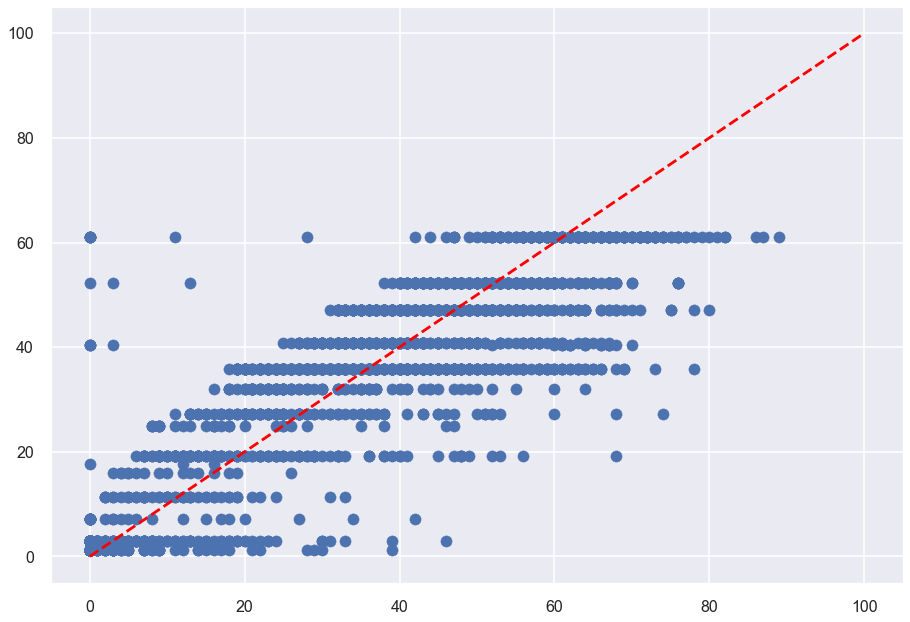

In [142]:
plot_results(reg_metrics, y_test_reg, y_test_class, DT_Predict)
#plt.title("Results of Decision Tree Predictions with Optimal Parameters")
save_fig("results_of_DT_predictions")
plt.show()

In [143]:
# feature_df_dt = pd.DataFrame({
#     'Importance': DT_Model.feature_importances_,
#     'Features': features
# })

# feature_df_dt.sort_values(by='Importance', ascending=False)

### Linear SVR

Optimisation de la pénalisation (paramètre $C$) par validation croisée.

In [144]:
param = [{
    "C": [0.4, 0.5, 0.6, 0.8, 1., 1.4]
}]

LSVR_Model = GridSearchCV(LinearSVR(), param, cv=10)
LSVR_Model.fit(X_train_scaled, y_train_reg)
LSVR_Predict = LSVR_Model.predict(X_test_scaled)

# Paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (LSVR_Model.best_score_, LSVR_Model.best_params_))

Meilleur score = 0.735477, Meilleur paramètre = {'C': 1.4}


In [145]:
mse_scores.append(mean_squared_error(y_test_reg, LSVR_Predict))
r2_scores.append(r2_score(y_test_reg, LSVR_Predict))
evs_scores.append(explained_variance_score(y_test_reg, LSVR_Predict))

Mean Squared Error : 118.00711
R2 Score : 0.75207
Explained Variance Score : 0.75696

Converting regression to classification...
Accuracy score: 0.664 

Saving figure results_of_LSVR_predictions


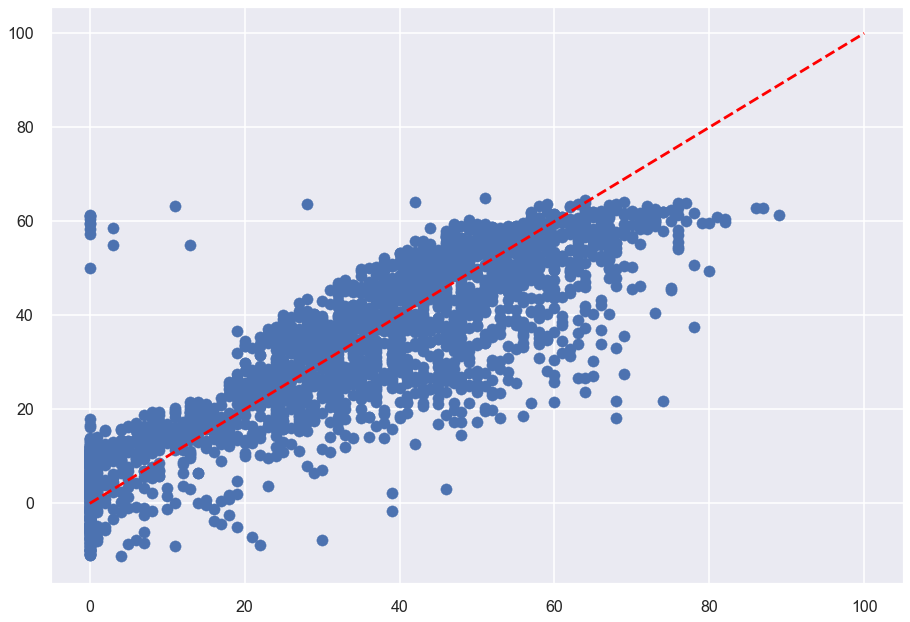

In [146]:
plot_results(reg_metrics, y_test_reg, y_test_class, LSVR_Predict)
#plt.title("Results of Linear SVR Predictions with Optimal Parameter")
save_fig("results_of_LSVR_predictions")
plt.show()

In [147]:
# feature_df_lsvr = pd.DataFrame({
#     'Coefficients': LSVR_Model.coef_,
#     'Features': features
# })

# feature_df_lsvr.sort_values(by='Coefficients', ascending=False)

### SVR

Optimisation de la pénalisation (paramètre $C$) par validation croisée.

In [148]:
param = [{
    "C": [0.4, 0.5, 0.6, 0.8, 1, 1.4]
}]

SVR_Model = GridSearchCV(SVR(), param, cv=10)
SVR_Model.fit(X_train_scaled, y_train_reg)
SVR_Predict = SVR_Model.predict(X_test_scaled)

# Paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" %
      (SVR_Model.best_score_, SVR_Model.best_params_))

Meilleur score = 0.735052, Meilleur paramètre = {'C': 1.4}


In [149]:
mse_scores.append(mean_squared_error(y_test_reg, SVR_Predict))
r2_scores.append(r2_score(y_test_reg, SVR_Predict))
evs_scores.append(explained_variance_score(y_test_reg, SVR_Predict))

Mean Squared Error : 119.74166
R2 Score : 0.74843
Explained Variance Score : 0.75345

Converting regression to classification...
Accuracy score: 0.6568 

Saving figure results_of_SVR_predictions


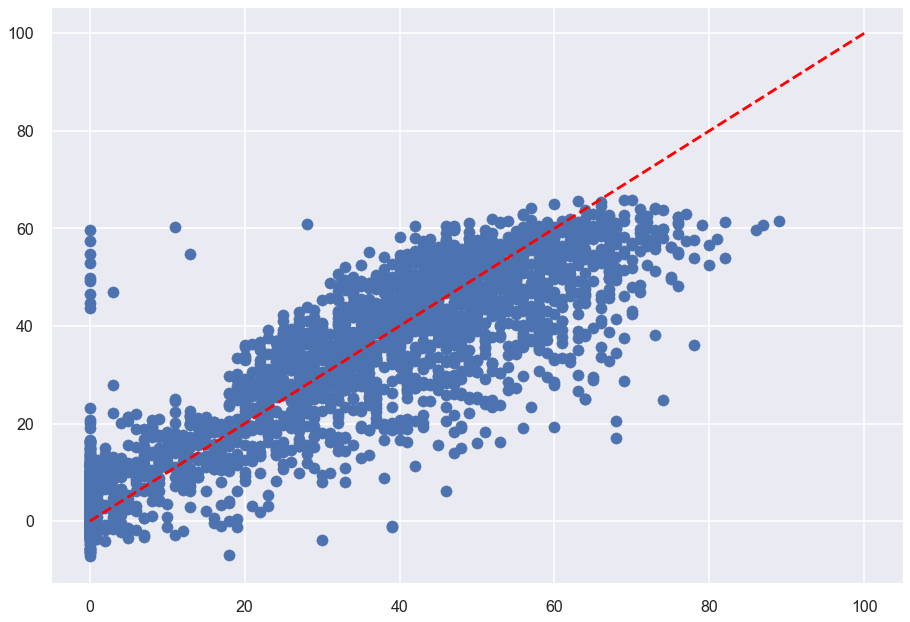

In [150]:
plot_results(reg_metrics, y_test_reg, y_test_class, SVR_Predict)
#plt.title("Results of SVR Predictions with Optimal Parameter")
save_fig("results_of_SVR_predictions")
plt.show()

### Réseaux de neuronnes

In [151]:
n_inputs, n_outputs = X_train.shape[1], 1
model = get_NN_model(n_inputs, n_outputs, 'regression')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               1400      
_________________________________________________________________
dense_5 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 31,751
Trainable params: 31,751
Non-trainable params: 0
_________________________________________________________________


In [152]:
MM_scaler = MinMaxScaler()

X_train_scaled = MM_scaler.fit_transform(X_train)
X_test_scaled = MM_scaler.transform(X_test)

In [153]:
history = model.fit(X_train_scaled, y_train_reg, epochs=200, batch_size=30,
                    validation_data=(X_test_scaled, y_test_reg), verbose=0)
NN_Predict = model.predict(X_test_scaled)

Saving figure keras_learning_curves_plot_reg


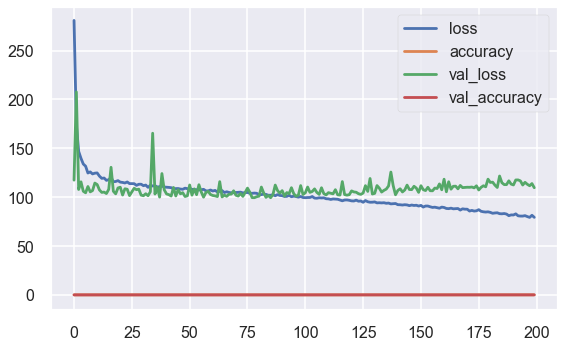

In [154]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.ylim(0, 1)
save_fig("keras_learning_curves_plot_reg")
plt.show()

In [155]:
mse_scores.append(mean_squared_error(y_test_reg, NN_Predict))
r2_scores.append(r2_score(y_test_reg, NN_Predict))
evs_scores.append(explained_variance_score(y_test_reg, NN_Predict))

Mean Squared Error : 109.66061
R2 Score : 0.76961
Explained Variance Score : 0.77079

Converting regression to classification...
Accuracy score: 0.6832 

Saving figure results_of_NN_predictions


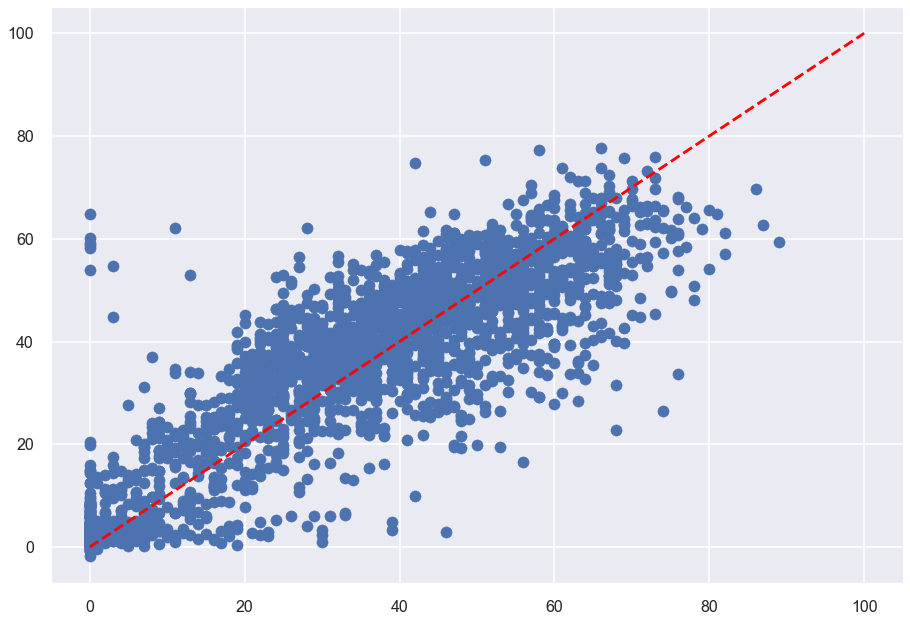

In [156]:
plot_results(reg_metrics, y_test_reg, y_test_class, NN_Predict)
#plt.title("Results of NN Predictions")
save_fig("results_of_NN_predictions")
plt.show()

In [157]:
regression_scores = pd.DataFrame({
    'Model': [
        'Linear Regression', 'Lasso', 'Ridge', 'Elastic Net',
        'Random Forest', 'Decision Trees', 'Linear SVR',
        'SVR', 'Neural Network'
    ],
    'Mean Squared Error': mse_scores,
    'R2 Scores': r2_scores,
    'Explained Variance Score': evs_scores
})

regression_scores

,Model,Mean Squared Error,R2 Scores,Explained Variance Score
0,Linear Regression,115.075204,0.758232,0.758258
1,Lasso,115.030540,0.758326,0.758352
2,Ridge,115.077731,0.758227,0.758253
3,Elastic Net,115.135667,0.758105,0.758132
4,Random Forest,98.113834,0.793867,0.793870
5,Decision Trees,104.573636,0.780296,0.780415
6,Linear SVR,118.007107,0.752072,0.756962
7,SVR,119.741656,0.748428,0.753450
8,Neural Network,109.660612,0.769608,0.770786
